In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re
import ns
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units
from scipy.optimize import bisect


import ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
#plt.rc('font', family='serif')
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/projects/b1095/syr904/projects/isolated_MSP/plots/'

2.1.2


sum_cc 0.6842105263157895
sum_noncc 0.4
mean_cc 0.5111111111111111
mean_noncc 0.2582326638878363
median_cc 0.6666666666666667
median_noncc 0.2
sum_tot 0.4642857142857143
mean_tot 0.330483648808772
[0.0, 0.5, 1.0, 0.0, 1.0, 0.0, 0.8333333333333334, 0.8888888888888888, 0.8888888888888888, 0.0] [0.3448275862068966, 0.42857142857142855, 0.2, 0.7333333333333333, 0.0, 0.14285714285714285, 0.0, 0.0, 0.3333333333333333, 0.5, 0.0, 0.0, 0.48717948717948717, 0.5, 0.6666666666666666, 0.8333333333333334, 0.0, 0.2857142857142857, 0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.0]
Ks_2sampResult(statistic=0.45999999999999996, pvalue=0.06685063010093223)
0.18421052631578946
0.24390243902439024
0.22110552763819097


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in true_divide


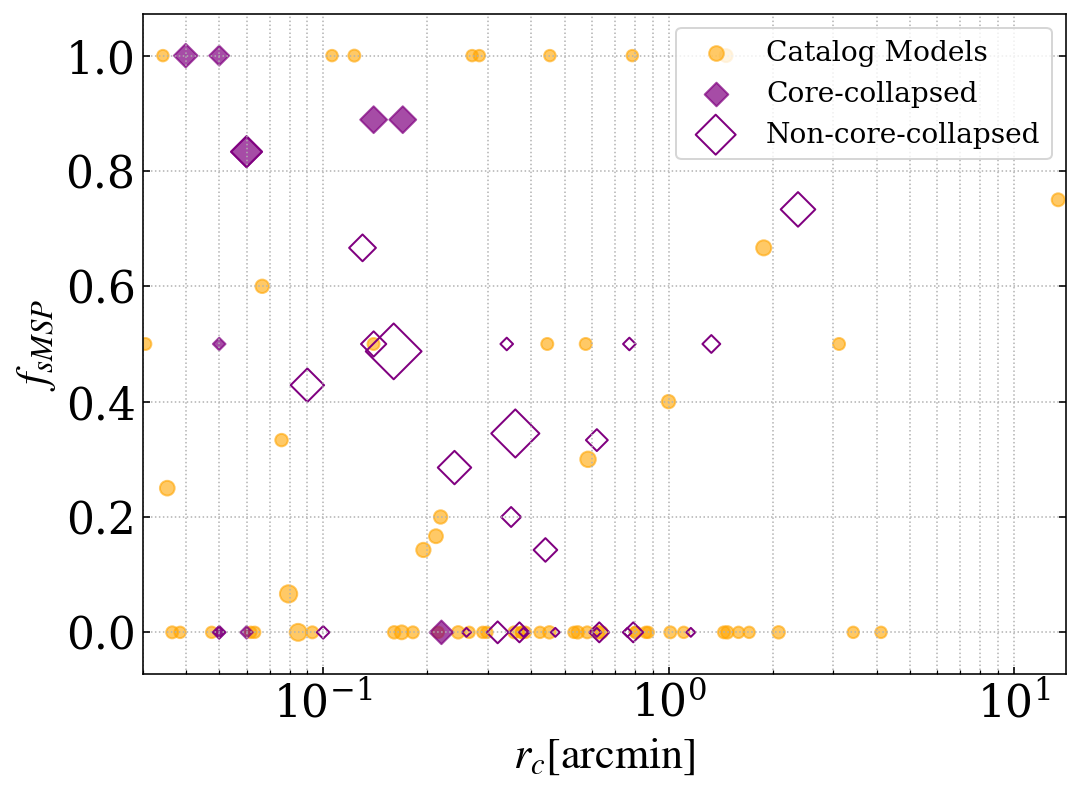

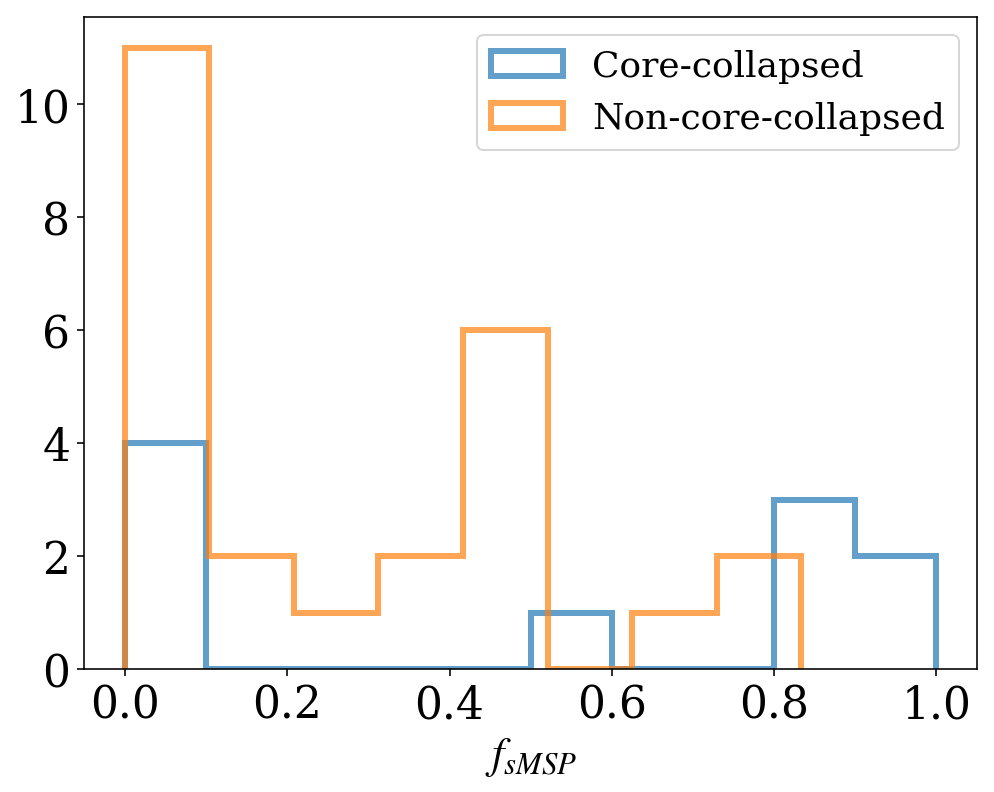

In [30]:
##Catalog Model Check
## isolated MSP fracion as a function of rc/rh
##Observed cluster rc and rh and Nmsp
data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
rc_psrcat = data_gcmsp['rc']; rhl_psrcat = data_gcmsp['rhl']
#print(rc_psrcat, data_gcmsp['name'])
Ntmsp = data_gcmsp['ntot'].values; Nbmsp = data_gcmsp['nbin'].values
CCst = data_gcmsp['cc'].values
r_ratio_psrcat = (rc_psrcat/rhl_psrcat)[Nbmsp!='*']
rhl_psrcat = rhl_psrcat[Nbmsp!='*']
rc_psrcat = rc_psrcat[Nbmsp!='*']
Ntmsp = Ntmsp[Nbmsp!='*']; CCst = CCst[Nbmsp!='*']
Nbmsp = Nbmsp[Nbmsp!='*']
Nsmsp = Ntmsp-Nbmsp


#print(np.sum(Nsmsp[r_ratio_psrcat<=0.2])/np.sum(Ntmsp[r_ratio_psrcat<=0.2]))
#print(np.sum(Nsmsp[r_ratio_psrcat>0.2])/np.sum(Ntmsp[r_ratio_psrcat>0.2]))
print('sum_cc', np.sum(Nsmsp[CCst==1])/np.sum(Ntmsp[CCst==1]))
print('sum_noncc', np.sum(Nsmsp[CCst!=1])/np.sum(Ntmsp[CCst!=1]))
print('mean_cc', np.mean(Nsmsp[CCst==1]/Ntmsp[CCst==1]))
print('mean_noncc', np.mean(Nsmsp[CCst!=1]/Ntmsp[CCst!=1]))
print('median_cc', np.median(Nsmsp[CCst==1]/Ntmsp[CCst==1]))
print('median_noncc', np.median(Nsmsp[CCst!=1]/Ntmsp[CCst!=1]))
print('sum_tot', np.sum(Nsmsp)/np.sum(Ntmsp))
print('mean_tot', np.mean(Nsmsp/Ntmsp))


fcc = list(Nsmsp[CCst==1]/Ntmsp[CCst==1])
fnoncc = list(Nsmsp[CCst!=1]/Ntmsp[CCst!=1])
print(fcc, fnoncc)
##K-S test to check if the two distributions are statistically different.
from scipy import stats
print(stats.ks_2samp(fcc, fnoncc))


#############################
data_nmsp = np.genfromtxt('/projects/b1095/syr904/projects/isolated_MSP/nmsp_rc_rh_12000myr.dat')
datapath = np.genfromtxt('/projects/b1095/syr904/projects/GCE/catalog/path_allfinished_newruns_maingrid.dat', 
                         dtype=str)
modelno = data_nmsp[:,0].astype(int)
sourcedir = datapath[:,0][modelno]
Rg = []
for xx in range(len(sourcedir)):
    n, zm, r_g, r_v = uc.find_init_conditions(sourcedir[xx])
    Rg.append(r_g)
Rg=np.array(Rg)
    
rc_obs = data_nmsp[:,5]; rhl_obs = data_nmsp[:,6]
nmsp_sin = data_nmsp[:,7]; nmsp_bin = data_nmsp[:,8]
r_ratio = rc_obs/rhl_obs
rc_obs_arcmin = uc.pc2arcsec(Rg, rc_obs)/60.

print(np.sum(nmsp_sin[r_ratio<=0.2])/np.sum(nmsp_sin[r_ratio<=0.2]+nmsp_bin[r_ratio<=0.2]))
print(np.sum(nmsp_sin[r_ratio>0.2])/np.sum(nmsp_sin[r_ratio>0.2]+nmsp_bin[r_ratio>0.2]))
print(np.sum(nmsp_sin)/np.sum(nmsp_sin+nmsp_bin))


##############################
r_ratio_bins = np.linspace(np.min(r_ratio), np.max(r_ratio), 16)
r_ratio_mean = []; nmsp_bin_tot = []; nmsp_sin_tot = []
for ii in range(len(r_ratio_bins)-1):
    r_ratio_mean.append((r_ratio_bins[ii+1]+r_ratio_bins[ii])/2.)
    nmsp_bin_tot.append(0); nmsp_sin_tot.append(0)
    for xx in range(len(r_ratio)):
        if r_ratio_bins[ii]<=r_ratio[xx]<=r_ratio_bins[ii+1]:
            nmsp_bin_tot[-1]+=nmsp_bin[xx]
            nmsp_sin_tot[-1]+=nmsp_sin[xx]

nmsp_bin_tot = np.array(nmsp_bin_tot)
nmsp_sin_tot = np.array(nmsp_sin_tot)
r_ratio_mean = np.array(r_ratio_mean)


fig, axs = plt.subplots(figsize = (8, 6))
axs.scatter(rc_obs_arcmin, nmsp_sin/(nmsp_sin+nmsp_bin), 
            alpha=0.6, color = 'orange', s = (nmsp_sin+nmsp_bin)*3+30,
            label = 'Catalog Models')
#axs.scatter(r_ratio_mean, 
#            nmsp_sin_tot/(nmsp_bin_tot+nmsp_sin_tot),
#           alpha=0.7, s=50, label = 'Catalog Models')
axs.scatter((r_ratio_psrcat*rhl_psrcat)[CCst==1], (Nsmsp/Ntmsp)[CCst==1],
            marker = 'D', s=Ntmsp[CCst==1]*10, alpha=0.7,
            edgecolor = 'purple', facecolor = 'purple',
            label = 'Core-collapsed')
axs.scatter((r_ratio_psrcat*rhl_psrcat)[CCst==0], (Nsmsp/Ntmsp)[CCst==0],
            marker = 'D', s=Ntmsp[CCst==0]*10, facecolor = 'none',
            edgecolor = 'purple',
            label = 'Non-core-collapsed')
#axs.set_xlabel(r'$r_c/r_{hl}$')
axs.set_xlabel(r'$r_c \rm{[arcmin]}$')
axs.set_xlim(xmin = 0.03)
axs.set_xscale('log')
axs.set_ylabel(r'$f_{sMSP}$')
axs.legend(loc='upper right', fontsize=14, frameon=True)
axs.grid(linestyle=':',which='major',linewidth='0.75')
axs.grid(linestyle=':',which='minor',linewidth='0.75')
axs.tick_params(top=False, right=True, direction = 'in', which='both')

fig.tight_layout()
plt.savefig(savepath+'fsmap_rc_comparison.pdf', dpi=300)


plt.figure(figsize=(8,6))
plt.hist(fcc,
        lw=3, alpha=0.7,
         histtype='step',label = 'Core-collapsed')
plt.hist(fnoncc, bins=8,
         histtype='step', lw=3, alpha=0.7,
         label = 'Non-core-collapsed')
plt.xlabel(r'$f_{sMSP}$')
plt.legend(fontsize=18)

In [15]:
##Total fraction of isolated MSPs in CC clusters
data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
#print(data_gcmsp['name'][data_gcmsp['cc']==1])
nbmsp = data_gcmsp['nbin']
ntmsp = data_gcmsp['ntot'][nbmsp!='*']
ccst = data_gcmsp['cc'][nbmsp!='*']
nbmsp = nbmsp[nbmsp!='*']
ntmsp_cc = ntmsp[ccst==1]; nbmsp_cc = nbmsp[ccst==1]
ntmsp_noncc = ntmsp[ccst==0]; nbmsp_noncc = nbmsp[ccst==0]
#print(ntmsp_cc)
#print(nbmsp_cc)

print(np.mean(nbmsp/ntmsp))
print(np.mean(nbmsp_cc/ntmsp_cc), np.mean(nbmsp_noncc/ntmsp_noncc))

print(np.sum(nbmsp)/np.sum(ntmsp))
print(np.sum(nbmsp_cc)/np.sum(ntmsp_cc), np.sum(nbmsp_noncc)/np.sum(ntmsp_noncc))

0.669516351191228
0.48888888888888893 0.7417673361121636
0.5357142857142857
0.3157894736842105 0.6


254
65 74


/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


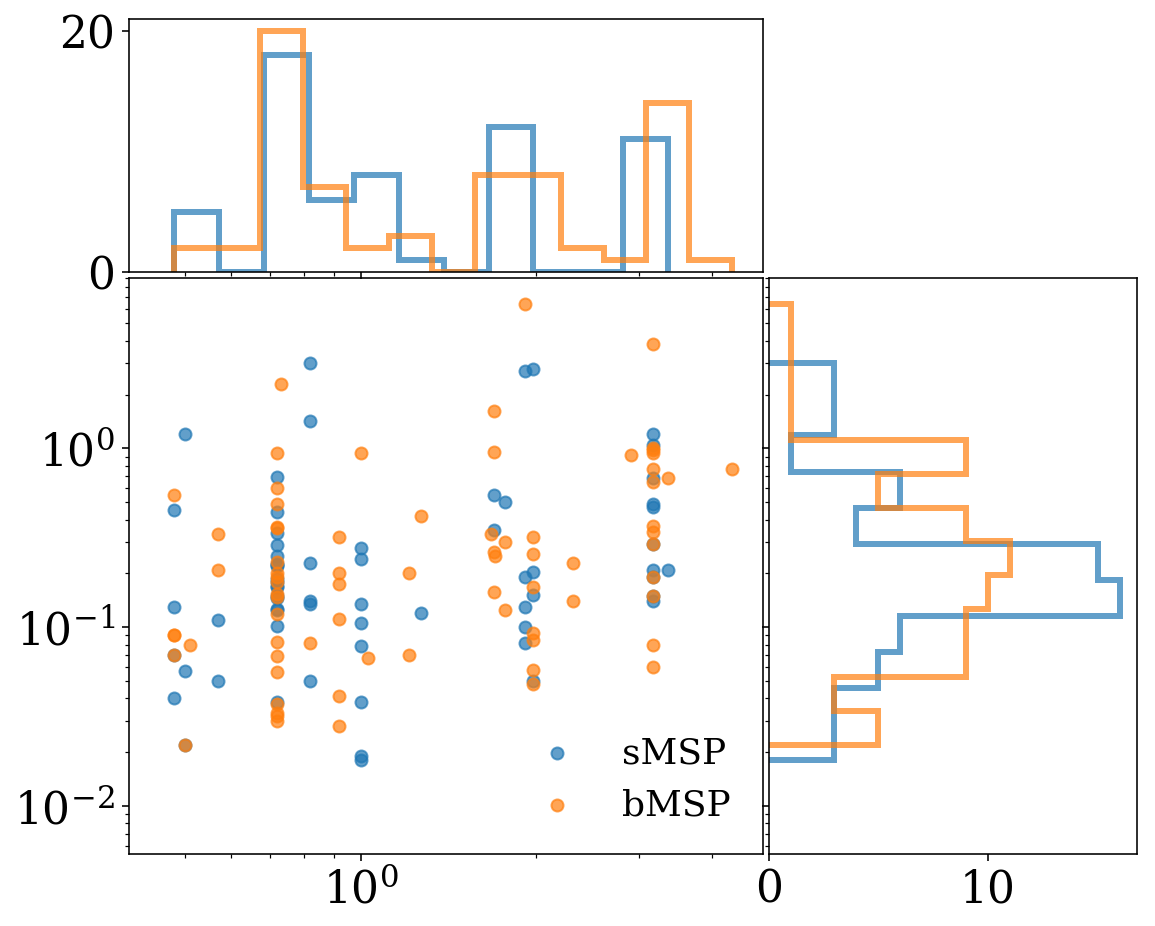

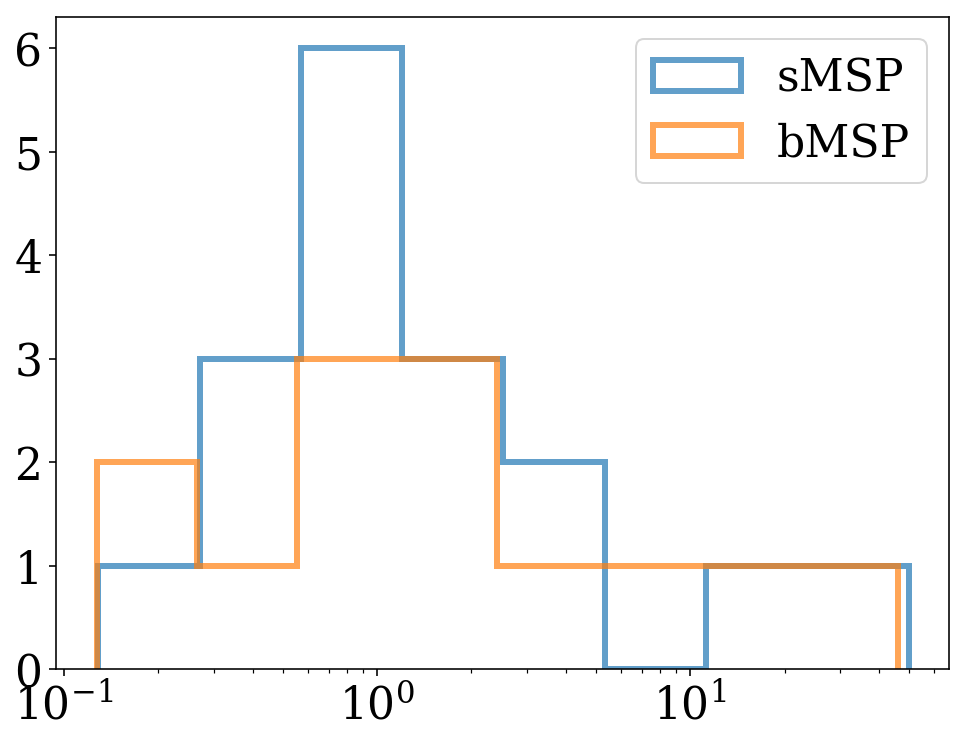

In [19]:
##Offsets
Poff, Offset, Binoff, Nameoff, Clusteroff = pc.readdata_freire(spinflag=0,offsetflag=1)
Offset = np.array(Offset)
Binoff = np.array(Binoff)
Poff = np.array(Poff)

print(len(Offset[Binoff==0]), len(Offset[Binoff==1]))

data_gcmsp = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
cluname = np.array(data_gcmsp['name']); ccst = np.array(data_gcmsp['cc'])
cnames = []
for ii in range(len(cluname)):
    cnames.append(cluname[ii].split()[1])
cnames = np.array(cnames)

CCoff = []; Rcoff = []; Rhoff = []
for jj in range(len(Clusteroff)):
    for kk in range(len(cnames)):
        if cnames[kk]==Clusteroff[jj]:
            cc = ccst[kk]
            rc = data_gcmsp['rc'][kk]
            rh = data_gcmsp['rhl'][kk]
    CCoff.append(cc); Rcoff.append(rc); Rhoff.append(rh)
CCoff=np.array(CCoff)
Rcoff=np.array(Rcoff); Rhoff=np.array(Rhoff)
#print(Rcoff)

Ps = Poff[Binoff==0]; Offs = Offset[Binoff==0]
Pb = Poff[Binoff==1]; Offb = Offset[Binoff==1]
CCs = CCoff[Binoff==0]
CCb = CCoff[Binoff==1]
Rcs = Rcoff[Binoff==0]; Rhs = Rhoff[Binoff==0]
Rcb = Rcoff[Binoff==1]; Rhb = Rhoff[Binoff==1]

def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1, y1,
               alpha=0.7,
               label = 'sMSP')
    ax.scatter(x2, y2,
               alpha=0.7,
               label='bMSP')
    #ax.scatter(x3, y3,
    #           alpha=0.7,
    #           label = 'nonCC-bMSP')
    #ax.scatter(x4, y4,
    #           alpha=0.7,
    #           label='CC-bMSP')
    
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 12), 
                  log=False, histtype = 'step', lw = 3, alpha=0.7)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 12), orientation='horizontal',
                 log=False, histtype = 'step', lw = 3, alpha=0.7)
    ax_histx.hist(x2, bins=np.logspace(np.log10(np.min(x2)), np.log10(np.max(x2)), 14), 
                  log=False, histtype = 'step', lw = 3, alpha=0.7)
    ax_histy.hist(y2, bins=np.logspace(np.log10(np.min(y2)), np.log10(np.max(y2)), 14), orientation='horizontal',
                 log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histx.hist(x3, bins=np.logspace(np.log10(np.min(x3)), np.log10(np.max(x3)), 12), 
    #              log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histy.hist(y3, bins=np.logspace(np.log10(np.min(y3)), np.log10(np.max(y3)), 12), orientation='horizontal',
    #             log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histx.hist(x4, bins=np.logspace(np.log10(np.min(x4)), np.log10(np.max(x4)), 14), 
    #              log=False, histtype = 'step', lw = 3, alpha=0.7)
    #ax_histy.hist(y4, bins=np.logspace(np.log10(np.min(y4)), np.log10(np.max(y4)), 14), orientation='horizontal',
    #             log=False, histtype = 'step', lw = 3, alpha=0.7)
    
    #ax.set_xlim(xmin = 0.004, xmax = 1.5)
    #ax.set_ylim(ymin = 0.01, ymax = 300)
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlabel(r'$Offset/r_{hl}$')
    #ax.set_ylabel(r'$P\,\rm{(ms)}$')
    ax.legend(loc = 'best', fontsize = 18, frameon = False)
    
    
    #ax_histx.set_yticks([1., 100., 500.])
    #ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(Rhoff[Binoff==0], Offset[Binoff==0],
             Rhoff[Binoff==1], Offset[Binoff==1],
             ax, ax_histx, ax_histy)
fig.tight_layout()


fig, ax = plt.subplots(figsize=(8,6))
ax.hist((Offs/Rcs)[CCs==1], 
        bins = np.logspace(np.log10(np.min((Offs/Rcs)[CCs==1])), np.log10(np.max((Offs/Rcs)[CCs==1])), 9),
        alpha=0.7, histtype='step', lw=3,
        label = 'sMSP')
ax.hist((Offb/Rcb)[CCb==1],
        bins = np.logspace(np.log10(np.min((Offb/Rcb)[CCb==1])), np.log10(np.max((Offb/Rcb)[CCb==1])), 9),
        alpha=0.7, histtype='step', lw=3,
        label = 'bMSP')

ax.legend(loc='best')

#ax.set_ylim(ymin = 0.8, ymax = 3000)
#ax.set_yscale('log')
ax.set_xscale('log')

In [2]:
paths = ['/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_alloff/',
        '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_nstde_s0.2/',
        '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_nstde_s0.8/',
        '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_wdtc/',
        '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_nstde_wdtc/',
        '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_nstde_s0.2_wdtc_gctc/',
        '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.8-rg8-z0.0002_iccatalog_micwd_newnsfile_dynwdmt_wdmass/']
model_label = ['Fiducial', 'TDE0.2', 'TDE0.8', 'WDTC', 'TDE0.2-WDTC', 'TDE0.2-WDTC-GCTC', 'WDTC_NSM']
snap_h5 = 'initial.snapshots.h5'
cs = ['gray','b', 'darkturquoise', 'yellowgreen', 'coral','orange','gold']

dpsr = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/psr_6752.xlsx',
                    names = ['psr_name','offset','spin','pdot','dm','pb','x','ecc','mc'])

#snapkeys = np.genfromtxt(paths[xx]+'snap_keys.txt', dtype='str')
#last_no = snapkeys[:,0][-1]; last_time = snap_h5[:,1][-1]
#
#last_key = '/'+last_no+'(t='+last_time+')'
#last_snap = cmct.Snapshot(fname=paths[xx]+snap_h5, snapshot_name=last_key, conv=paths[xx]+'initial.conv.sh')
#binflag = np.array(last_snap.data['binflag'])
#ktype = np.array(last_snap.data['startype'])[binflag!=1]
#k0 = np.array(last_snap.data['bin_startype0'])[binflag==1]
#k1 = np.array(last_snap.data['bin_startype1'])[binflag==1]
#
#bfield = np.array(last_snap.data['B'])[binflag!=1][ktype==13]
#b0 = np.array(last_snap.data['B0'])[binflag==1][k0==13]
#b1 = np.array(last_snap.data['B1'])[binflag==1][k1==13]
#pspin = twopi*yearsc/np.array(last_snap.data['ospin'])[binflag!=1][ktype==13]
#p0 = twopi*yearsc/np.array(last_snap.data['ospin0'])[binflag==1][k0==13]
#p1 = twopi*yearsc/np.array(last_snap.data['ospin1'])[binflag==1][k1==13]

allpsr: Fiducial 7.3354430379746836 8.670886075949367
allmsp: Fiducial 4.455696202531645 7.80379746835443
Nns: Fiducial 885.253164556962
low-mass bh? Fiducial 0.0
allpsr: TDE0.2 41.69285714285714 13.285714285714286
allmsp: TDE0.2 38.27142857142857 12.214285714285714
Nns: TDE0.2 934.5285714285715
low-mass bh? TDE0.2 0.0
allpsr: TDE0.8 9.914473684210526 7.703947368421052
allmsp: TDE0.8 4.197368421052632 6.046052631578948
Nns: TDE0.8 977.6907894736842
low-mass bh? TDE0.8 0.0
allpsr: WDTC 10.358024691358025 9.561728395061728
allmsp: WDTC 5.827160493827161 8.265432098765432
Nns: WDTC 902.6234567901234
low-mass bh? WDTC 0.0
allpsr: TDE0.2-WDTC 45.69651741293532 12.228855721393035
allmsp: TDE0.2-WDTC 41.43781094527363 11.492537313432836
Nns: TDE0.2-WDTC 957.1641791044776
low-mass bh? TDE0.2-WDTC 0.0
allpsr: TDE0.2-WDTC-GCTC 87.62735849056604 36.25471698113208
allmsp: TDE0.2-WDTC-GCTC 85.45283018867924 34.27358490566038
Nns: TDE0.2-WDTC-GCTC 977.7783018867924
low-mass bh? TDE0.2-WDTC-GCTC 0.0


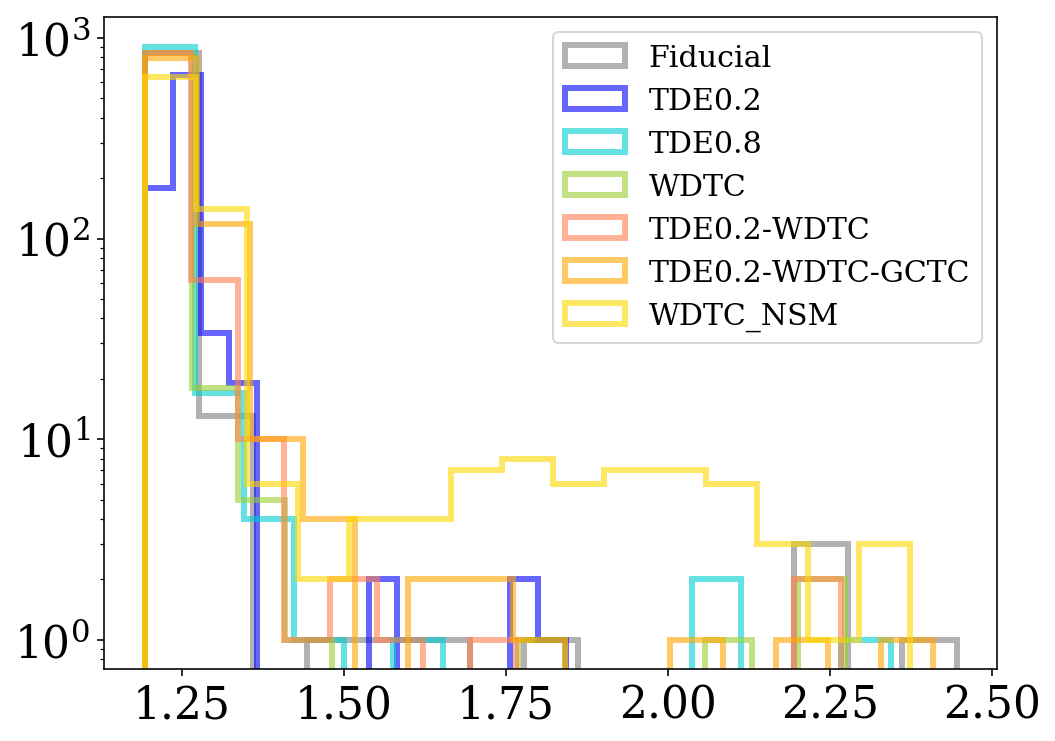

In [7]:
###Number of pulsars and their spin period and magnetic filed distribution
###Separating single and binary MSPs
fig, axs = plt.subplots(figsize=(8,6))
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    mall = []
    Bsin = []; Psin = []; msin = []
    Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
    thetime = [10000.,13000.]
    timestep_old=14000.
    npsr_sin = []; npsr_bin = []
    nmsp_sin = []; nmsp_bin = []
    nns = []
    nlbh = []
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                Psin = np.array(Psin)
                Pbin = np.array(Pbin)
                mall = np.array(mall)
                npsr_sin.append(len(Psin)); npsr_bin.append(len(Pbin))
                nmsp_sin.append(len(Psin[Psin<=0.03])); nmsp_bin.append(len(Pbin[Pbin<=0.03]))
                nns.append(len(mall))
                nlbh.append(len(mall[mall>2.5]))
                mall = []
                Bsin = []; Psin = []; msin = []
                Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
                
            if int(data[2])!=1:
                mall.append(float(data[5]))
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bsin.append(float(data[7]))
                    Psin.append(float(data[9]))
                    msin.append(float(data[5]))
            else:
                if int(data[11])==13:
                    mall.append(float(data[5]))
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bbin.append(float(data[7]))
                    Pbin.append(float(data[9]))
                    mbin.append(float(data[5]))
                    mcomp.append(float(data[6]))
                    kcomp.append(int(data[12]))
                
                if int(data[12])==13:
                    mall.append(float(data[6]))
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    Bbin.append(float(data[8]))
                    Pbin.append(float(data[10]))
                    mbin.append(float(data[6]))
                    mcomp.append(float(data[5]))
                    kcomp.append(int(data[11]))  
            timestep_old = timestep
    
    print('allpsr:', model_label[xx], np.mean(npsr_sin), np.mean(npsr_bin))
    print('allmsp:', model_label[xx], np.mean(nmsp_sin), np.mean(nmsp_bin))
    
    print('Nns:', model_label[xx], np.mean(nns))
    print('low-mass bh?', model_label[xx], np.mean(nlbh))
    axs.hist(mall, bins=15,
             histtype='step', alpha=0.6, color = cs[xx], lw=3,
             label = model_label[xx])
    
                                                                 
    #axs[0].hist(Psin, 
    #            bins = np.logspace(np.log10(np.min(Psin)), np.log10(np.max(Psin)), 15),
    #            histtype='step', alpha=0.6, color = cs[xx], lw=3,
    #            label = model_label[xx])
    #axs[0].hist(Pbin, 
    #            bins = np.logspace(np.log10(np.min(Pbin)), np.log10(np.max(Pbin)), 10),
    #            histtype='step', alpha=0.6, color = cs[xx], lw=3, ls = '--',
    #            label = model_label[xx])
    #
    #axs[1].hist(Bsin, 
    #            bins = np.logspace(np.log10(np.min(Bsin)), np.log10(np.max(Bsin)), 15),
    #            histtype='step', alpha=0.6, color = cs[xx], lw=3,
    #            label = model_label[xx])
    #axs[1].hist(Bbin,
    #            bins = np.logspace(np.log10(np.min(Bbin)), np.log10(np.max(Bbin)), 10),
    #            histtype='step', alpha=0.6, color = cs[xx], lw=3, ls = '--',
    #            label = model_label[xx])
    
#axs[0].set_xscale('log')
#axs[1].set_xscale('log')
#axs[1].legend(loc = 'best')
axs.set_yscale('log')
axs.legend(loc='best', fontsize=15)

In [8]:
###Number of NS formed in WDWD collision
###PSR and non-PSR
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    wdwd_coll_file = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    id_coll = wdwd_coll_file[:,2].astype(np.int)
    print('N_ns_wdwd:', model_label[xx], len(id_coll))
    
    thetime = [10000.,13000.]
    IDsin = []; IDsin_coll = []; Psin = []
    IDbin = []; IDbin_coll = []; Pbin = []
    
    timestep_old=14000.
    nsin_psr = 0; nsin_msp = 0
    nbin_psr = 0; nbin_msp = 0
    nns_coll_sin = []; nns_coll_bin = []
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                IDsin = np.array(IDsin); Psin = np.array(Psin)
                IDbin = np.array(IDbin); Pbin = np.array(Pbin)
                IDsin_msp = IDsin[Psin<=0.03]
                IDbin_msp = IDbin[Pbin<=0.03]
                
                for ii in range(len(IDsin_coll)):
                    for jj in range(len(IDsin)):
                        if IDsin_coll[ii]==IDsin[jj]:
                            nsin_psr+=1
                            
                    for kk in range(len(IDsin_msp)):
                        if IDsin_coll[ii]==IDsin_msp[kk]:
                            nsin_msp+=1
                
                for ii in range(len(IDbin_coll)):
                    for jj in range(len(IDbin)):
                        if IDbin_coll[ii]==IDbin[jj]:
                            nbin_psr+=1
                            
                    for kk in range(len(IDbin_msp)):
                        if IDbin_coll[ii]==IDbin_msp[kk]:
                            nbin_msp+=1
    
                nns_coll_sin.append(len(IDsin_coll)-nsin_msp)
                nns_coll_bin.append(len(IDbin_coll)-nbin_msp)
    
                IDsin = []; IDsin_coll = []; Psin = []
                IDbin = []; IDbin_coll = []; Pbin = []
            
                nsin_psr = 0; nsin_msp = 0
                nbin_psr = 0; nbin_msp = 0
                
                
            if int(data[2])!=1:
                if int(data[3]) in id_coll:
                    IDsin_coll.append(int(data[3]))
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDsin.append(int(data[3]))
                    Psin.append(float(data[9]))
            else:
                if int(data[3]) in id_coll:
                    IDbin_coll.append(int(data[3]))
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDbin.append(int(data[3]))
                    Pbin.append(float(data[9]))
                    
                if int(data[4]) in id_coll:
                    IDbin_coll.append(int(data[4]))
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    IDbin.append(int(data[4]))
                    Pbin.append(float(data[10]))
                    
            timestep_old = timestep
                    
    #print('sin:', len(IDsin_coll), nsin_psr, nsin_msp)
    #print('bin:', len(IDbin_coll), nbin_psr, nbin_msp)
    print('sin:', model_label[xx], np.mean(nns_coll_sin))
    print('bin:', model_label[xx], np.mean(nns_coll_bin))
                

N_ns_wdwd: Fiducial 93
sin: Fiducial 38.18987341772152
bin: Fiducial 2.4050632911392404
N_ns_wdwd: TDE0.2 95
sin: TDE0.2 32.135714285714286
bin: TDE0.2 3.7
N_ns_wdwd: TDE0.8 67
sin: TDE0.8 20.769736842105264
bin: TDE0.8 5.0
N_ns_wdwd: WDTC 138
sin: WDTC 44.79012345679013
bin: WDTC 3.3580246913580245
N_ns_wdwd: TDE0.2-WDTC 153
sin: TDE0.2-WDTC 62.1044776119403
bin: TDE0.2-WDTC 2.373134328358209
N_ns_wdwd: TDE0.2-WDTC-GCTC 172
sin: TDE0.2-WDTC-GCTC 66.66509433962264
bin: TDE0.2-WDTC-GCTC 2.268867924528302
N_ns_wdwd: WDTC_NSM 125
sin: WDTC_NSM 22.12213740458015
bin: WDTC_NSM 6.190839694656488


In [8]:
###Pulsars and their spin period and magnetic filed distribution, and positions in the cluster
###Separating single and binary MSPs
###Identify collision products
Ball = []; Pall = []; mall = []; mcompall = []; kcompall = []; rposall = []
idnsall = []; idcompall = []
wdwdcollflagall = []; wdmscollflagall = []
psrflagall = []; mspflagall = []
modelnoall = []
for xx in range(5):
    B = []; P = []; m = []; mcomp = []; kcomp = []; rpos = []
    idns = []; idcomp = []
    wdwdcollflag = []; wdmscollflag = []
    psrflag = []; mspflag = []
    modelno = []
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    wdwd_coll_file = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    idwdwd_coll = wdwd_coll_file[:,2].astype(np.int)
    
    wdms_coll_file = np.genfromtxt(paths[xx]+'wdms_coll.dat')
    idwdms_coll = wdms_coll_file[:,2].astype(np.int)
    id_wdms = []

    thetime = 14000.
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime:
                break
            if float(data[1])*t_conv>=13000.:
                thetime = float(data[1])*t_conv
                #print(thetime)
                if int(data[2])!=1:
                    if int(data[3]) in idwdms_coll:
                        id_wdms.append(int(data[3]))
                    if float(data[7])>=float(data[9])**2*(0.17*10**12):
                        B.append(float(data[7]))
                        P.append(float(data[9]))
                        m.append(float(data[5]))
                        mcomp.append(-100)
                        kcomp.append(-100)
                        rpos.append(float(data[19])*l_conv)
                        idns.append(int(data[3]))
                        idcomp.append(-100)
                        modelno.append(xx)
                        psrflag.append(1)
                        
                        if P[-1]<=0.03:
                            mspflag.append(1)
                        else:
                            mspflag.append(0)
                            
                        if int(data[3]) in idwdwd_coll:
                            wdwdcollflag.append(1)
                        else:
                            wdwdcollflag.append(0)
                            
                        if int(data[3]) in idwdms_coll:
                            wdmscollflag.append(1)
                        else:
                            wdmscollflag.append(0)

                    else:
                        if int(data[3]) in idwdwd_coll:
                            wdwdcollflag.append(1)
                            
                            B.append(float(data[7]))
                            P.append(float(data[9]))
                            m.append(float(data[5]))
                            mcomp.append(-100)
                            kcomp.append(-100)
                            rpos.append(float(data[19])*l_conv
                            idns.append(int(data[3]))
                            idcomp.append(-100)
                            modelno.append(xx)
                            psrflag.append(0)
                            mspflag.append(0)
                            wdmscollflag.append(0)
           
                else:
                    if int(data[11])==13::
                        if int(data[3]) in idwdms_coll:
                            id_wdms.append(int(data[3]))
                        if float(data[7])>=float(data[9])**2*(0.17*10**12):
                            B.append(float(data[7]))
                            P.append(float(data[9]))
                            m.append(float(data[5]))
                            mcomp.append(float(data[6]))
                            kcomp.append(int(data[12]))
                            rpos.append(float(data[19])*l_conv)
                            idns.append(int(data[3]))
                            idcomp.append(int(data[4]))
                            modelno.append(xx)
                            psrflag.append(1)
                            
                            if P[-1]<=0.03:
                                mspflag.append(1)
                            else:
                                mspflag.append(0)
                                
                            if int(data[3]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                            else:
                                wdwdcollflag.append(0)
                                
                            if int(data[3]) in idwdms_coll:
                                wdmscollflag.append(1)
                            else:
                                wdmscollflag.append(0)

                        else:
                            if int(data[3]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                                
                                B.append(float(data[7]))
                                P.append(float(data[9]))
                                m.append(float(data[5]))
                                mcomp.append(float(data[6]))
                                kcomp.append(int(data[12]))
                                rpos.append(float(data[19])*l_conv)
                                idns.append(int(data[3]))
                                idcomp.append(int(data[4]))
                                modelno.append(xx)
                                psrflag.append(0)
                                mspflag.append(0)
                                wdmscollflag.append(0)

                            
                    if int(data[12])==13:
                        if int(data[4]) in idwdms_coll:
                            id_wdms.append(int(data[4]))
                        if float(data[8])>=float(data[10])**2*(0.17*10**12):
                            B.append(float(data[8]))
                            P.append(float(data[10]))
                            m.append(float(data[6]))
                            mcomp.append(float(data[5]))
                            kcomp.append(int(data[11]))
                            rpos.append(float(data[19])*l_conv)
                            idns.append(int(data[4]))
                            idcomp.append(int(data[3]))
                            modelno.append(xx)
                            psrflag.append(1)
                            
                            if P[-1]<=0.03:
                                mspflag.append(1)
                            else:
                                mspflag.append(0)
                                
                            if int(data[4]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                            else:
                                wdwdcollflag.append(0)
                                
                            if int(data[4]) in idwdms_coll:
                                wdmscollflag.append(1)
                            else:
                                wdmscollflag.append(0)

                        else:
                            if int(data[4]) in idwdwd_coll:
                                wdwdcollflag.append(1)
                                
                                B.append(float(data[8]))
                                P.append(float(data[10]))
                                m.append(float(data[6]))
                                mcomp.append(float(data[5]))
                                kcomp.append(int(data[11]))
                                rpos.append(float(data[19])*l_conv)
                                idns.append(int(data[4]))
                                idcomp.append(int(data[3]))
                                modelno.append(xx)
                                psrflag.append(0)
                                mspflag.append(0)
                                wdmscollflag.append(0)
                                
    P = np.array(P)
    mspflag = np.array(mspflag)
    wdwdcollflag = np.array(wdwdcollflag)
    wdmscollflag = np.array(wdmscollflag)
    
    allmsp = mspflag[mspflag==1]
    wdwdcoll_msp = wdwdcollflag[mspflag==1]
    wdmscoll_msp = wdmscollflag[mspflag==1]
                                
    print(xx, len(allmsp), len(wdwdcoll_msp[wdwdcoll_msp==1]), len(wdmscoll_msp[wdmscoll_msp==1]))
    print(len(id_wdms))
    
    Ball.append(B); Pall.append(P); mall.append(m); mcompall.append(mcomp)
    kcompall.append(kcomp); rposall.append(rpos)
    idnsall.append(idns); idcompall.append(idcomp)
    modelnoall.append(modelno)
    psrflagall.append(psrflag); mspflagall.append(mspflag)
    wdwdcollflagall.append(wdwdcollflag); wdmscollflagall.append(wdmscollflag)
    
                                
#np.savetxt('/projects/b1095/syr904/projects/isolated_MSP/ngc6752_pulsars.txt', 
#           np.c_[modelno, rpos, idns, idcomp, m, mcomp, B, P, kcomp, psrflag, mspflag, wdwdcollflag, wdmscollflag],
#           fmt = '%d %f %d %d %f %f %e %f %d %d %d %d %d', 
#           header = '1.Model 2.R[pc] 3.IDns 4.IDcomp 5.Mns[Msun] 6.Mcomp[Msun] 7.B[G] 8.P[sec] 9.Kcomp 10.PSRflag 11.MSPflag 12.WDWDCollflag 13.WDMSCollflag',
#           comments = '#', delimiter = '')

SyntaxError: invalid syntax (<ipython-input-8-464328f95f73>, line 77)

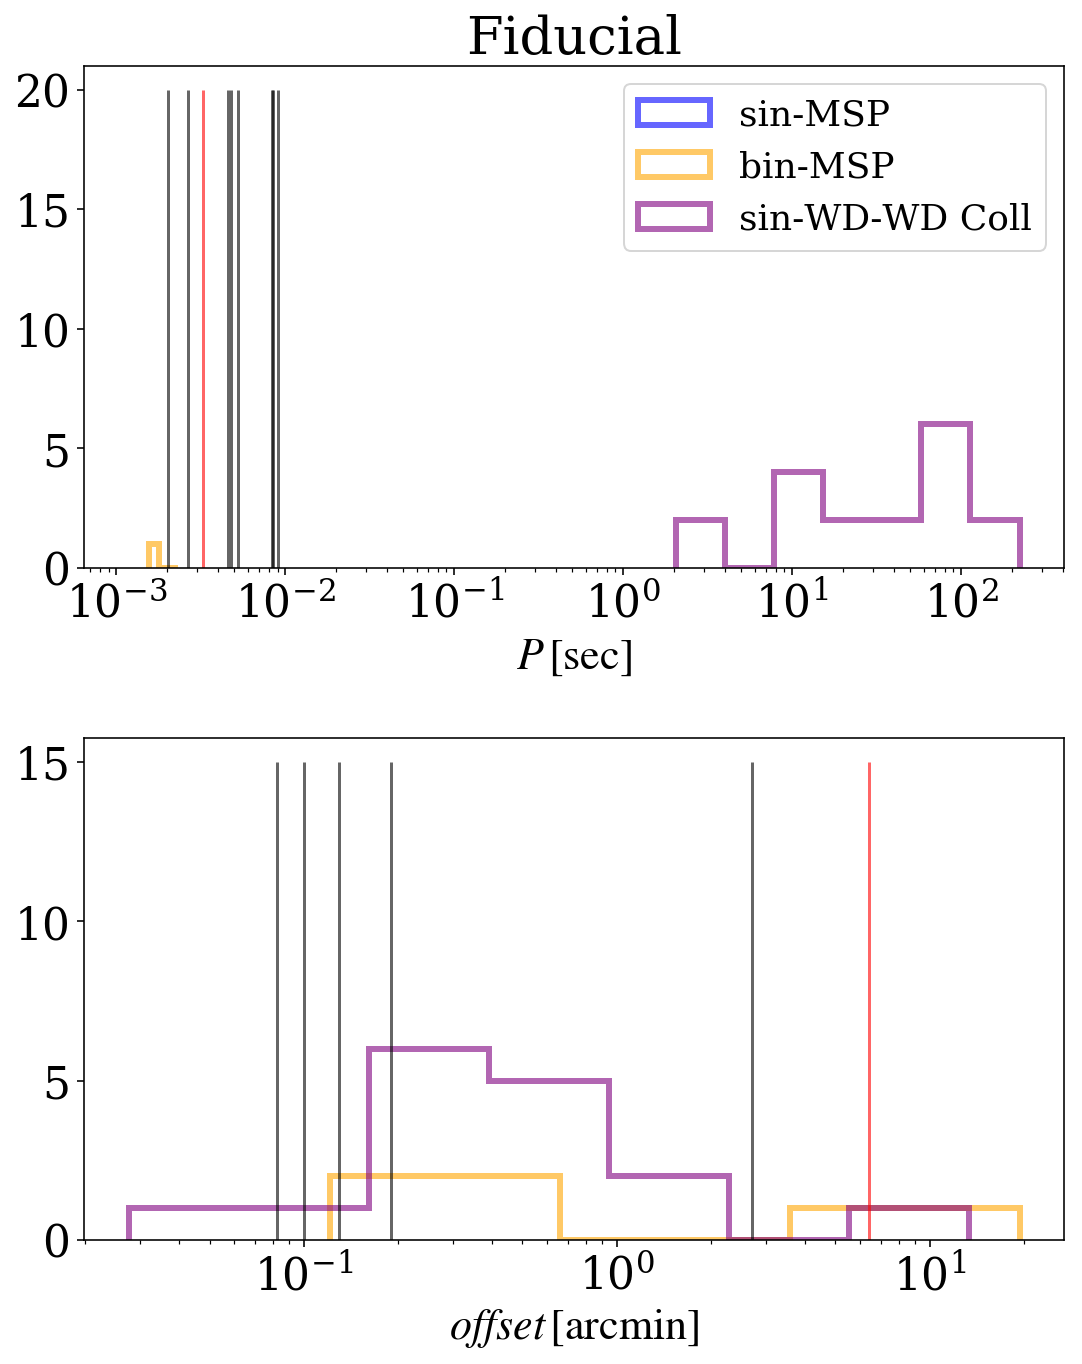

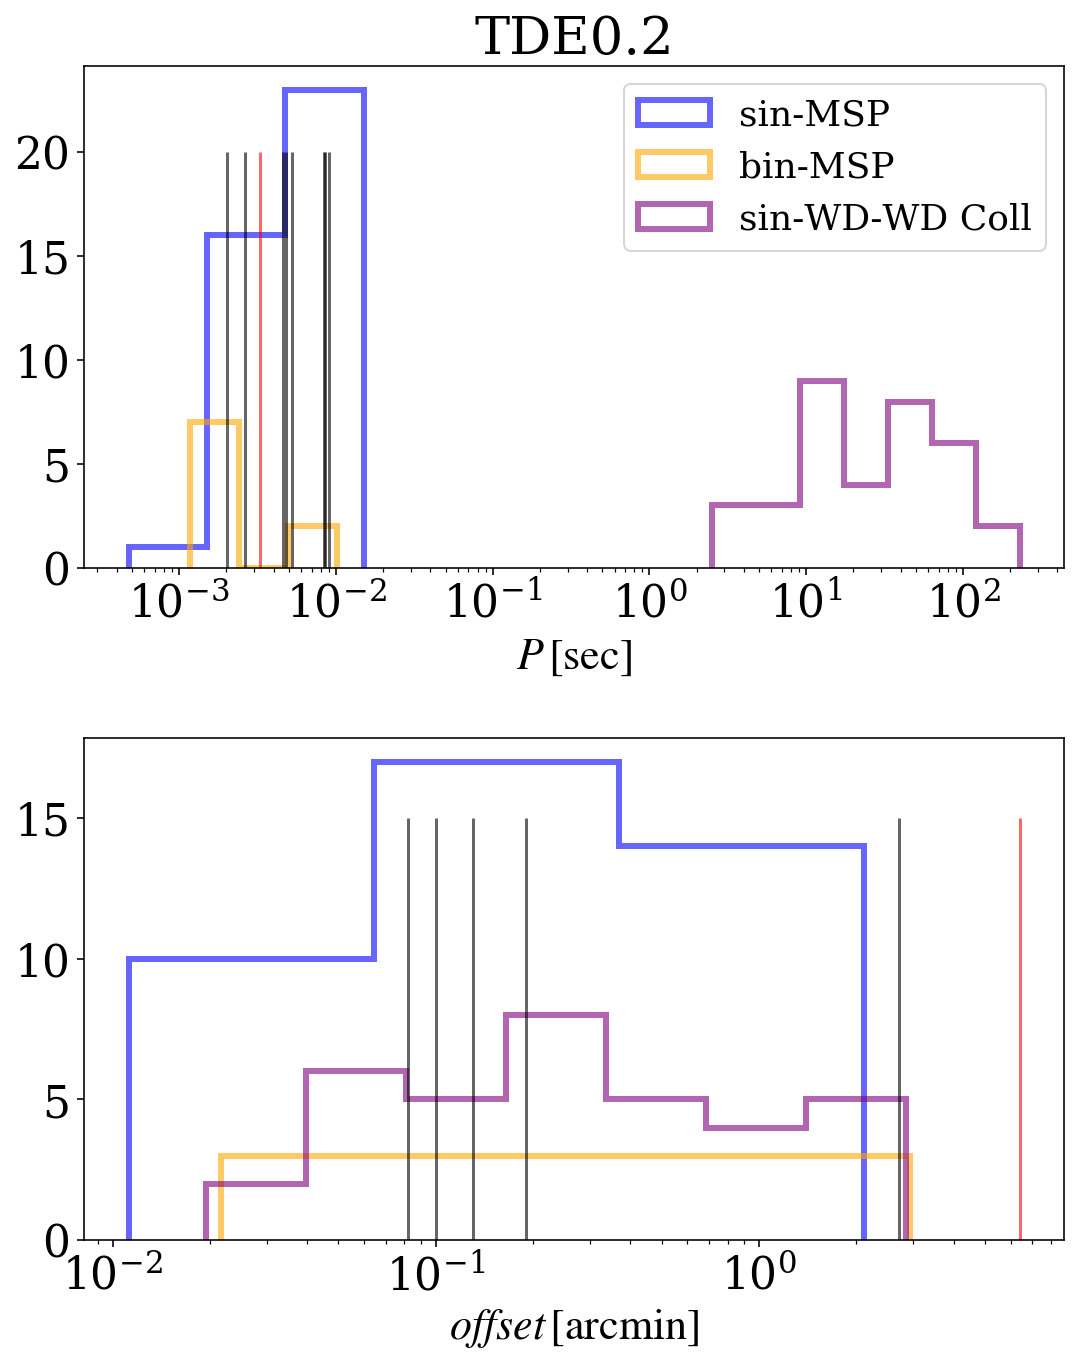

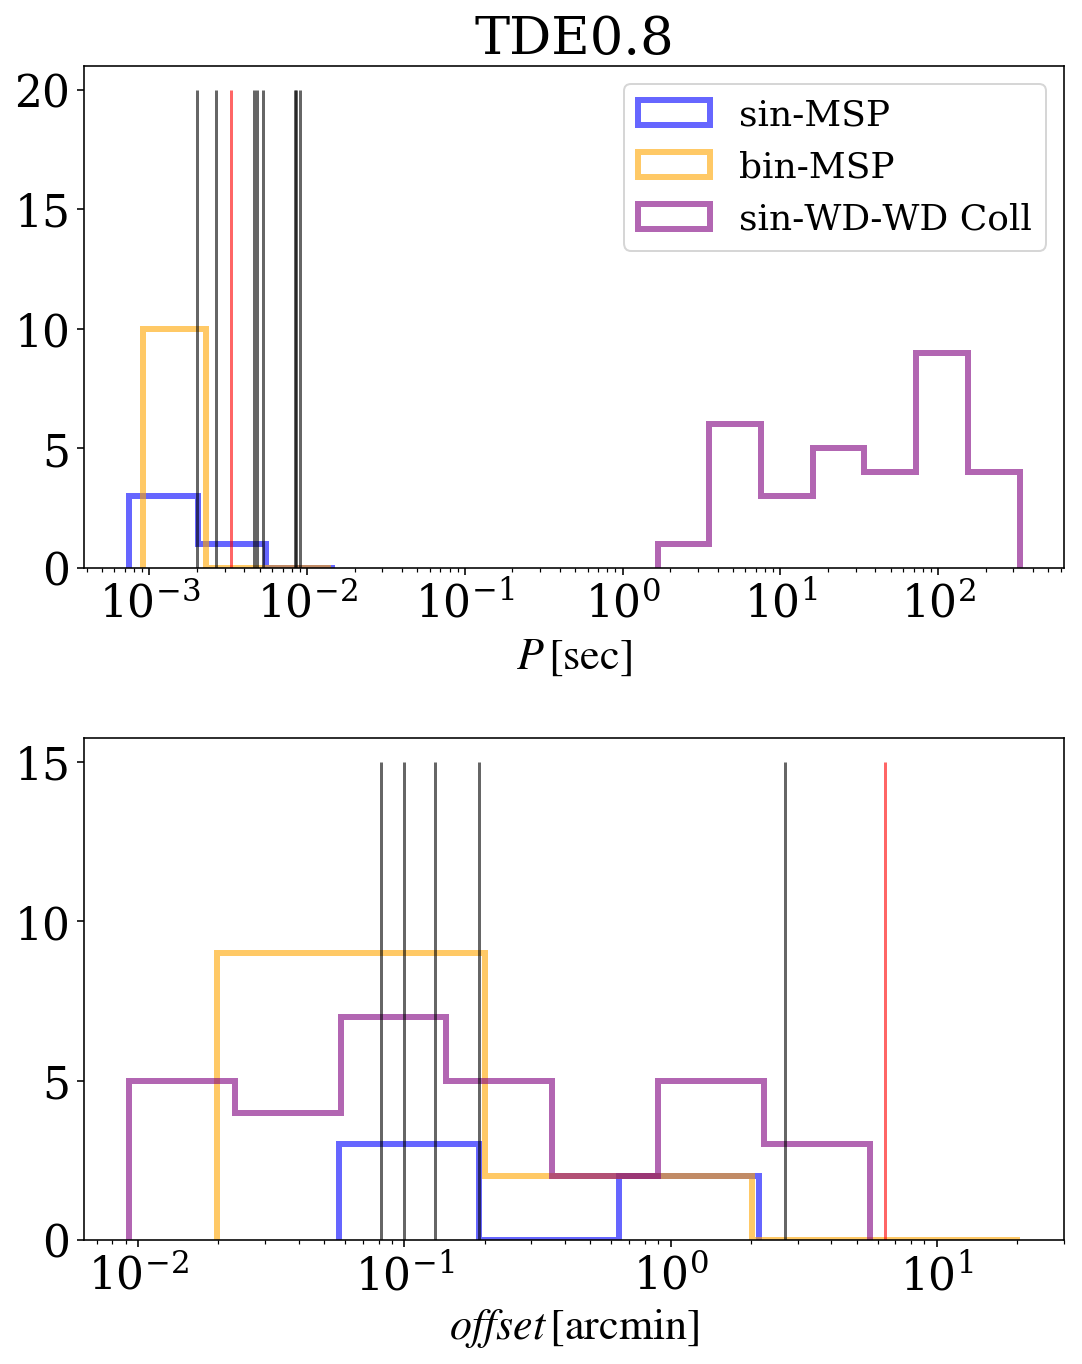

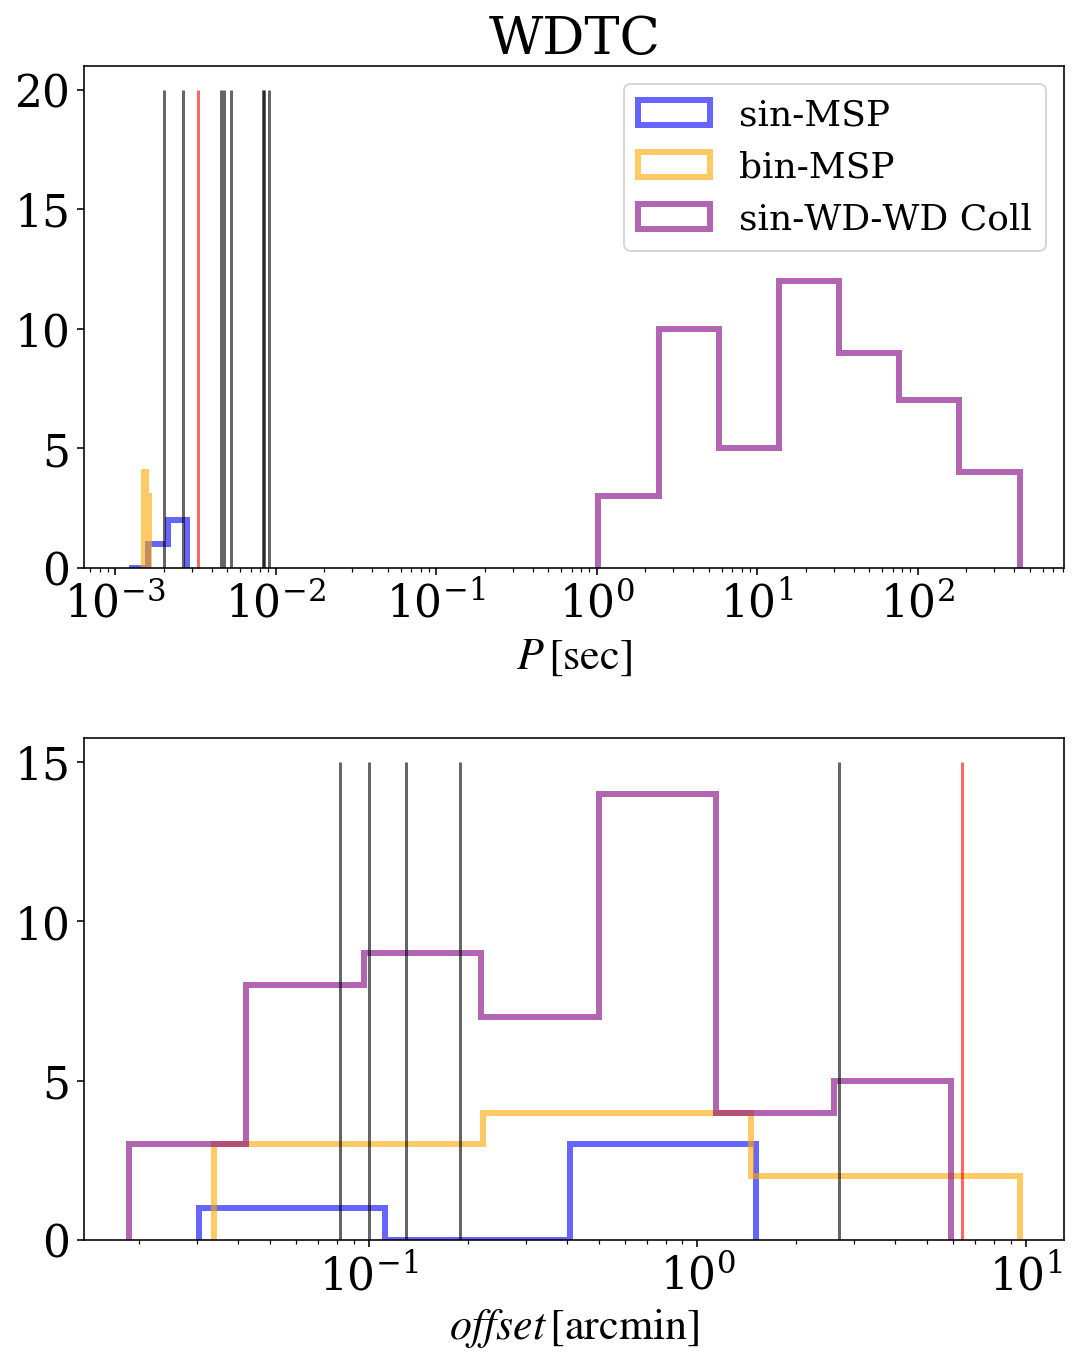

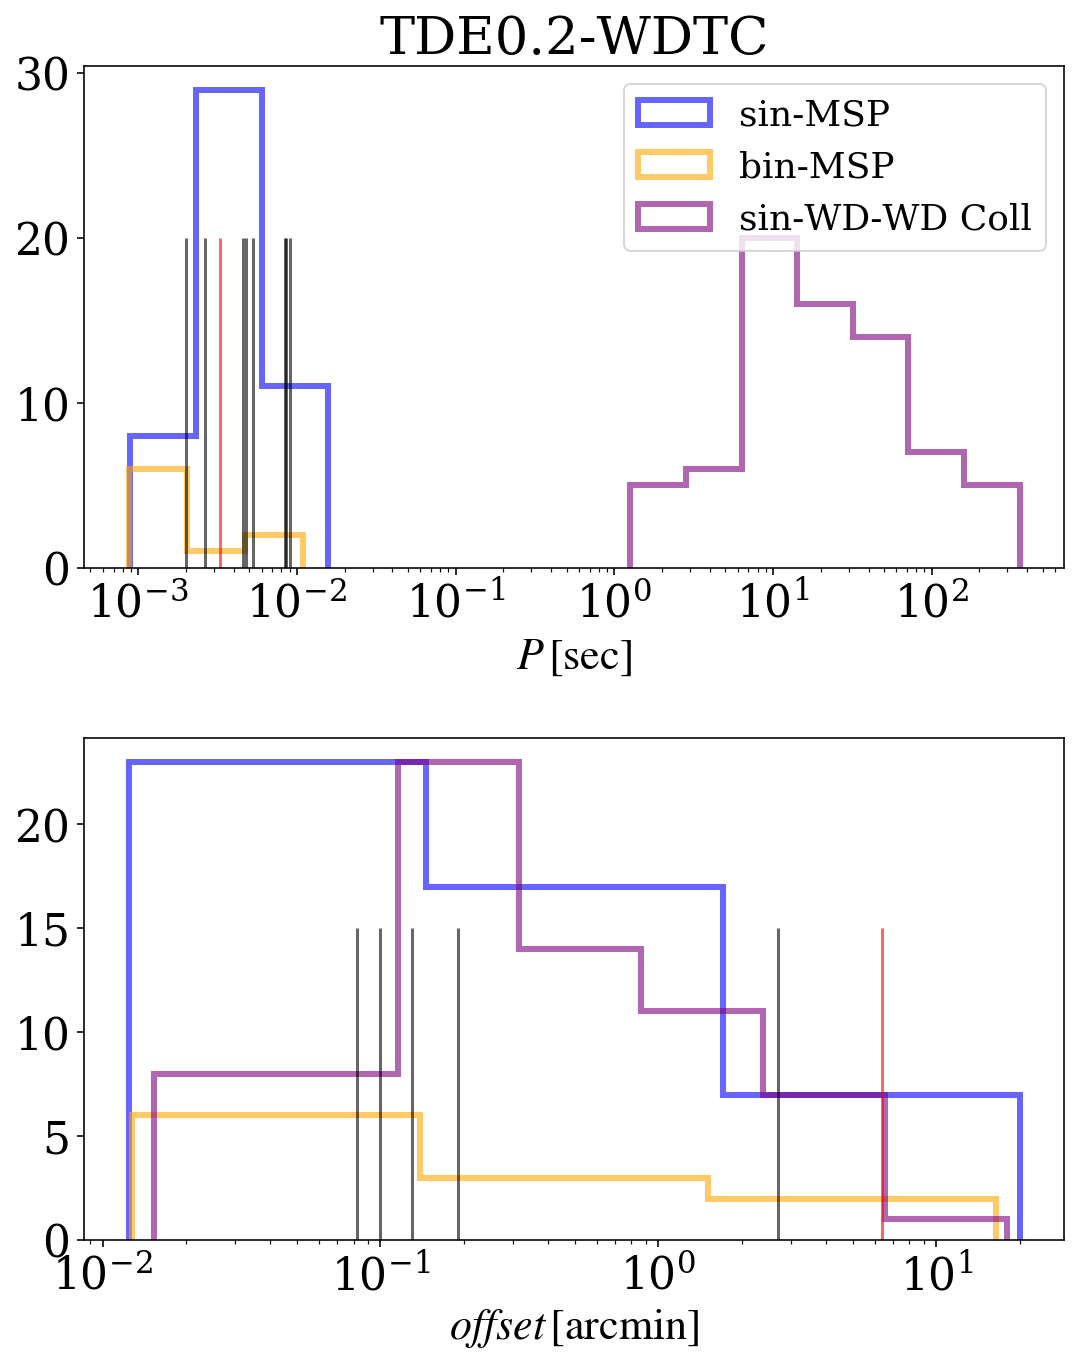

In [19]:
##Ppdot plot and radial distribution
for xx in range(len(paths)):
    P = np.array(Pall[xx])
    mspflag = np.array(mspflagall[xx])
    wdwdcollflag = np.array(wdwdcollflagall[xx])
    rpos = np.array(rposall[xx])
    idcomp = np.array(idcompall[xx])
    modelno = np.array(modelnoall[xx])
    
    wdwdcoll_msp = wdwdcollflag[mspflag==1]
    wdwdcoll_nonmsp = wdwdcollflag[mspflag!=1]
    
    Pmsp = P[mspflag==1]
    Pnonmsp = P[mspflag!=1]
    Pwdwd = Pnonmsp[wdwdcoll_nonmsp==1]
    
    idcomp_msp = idcomp[mspflag==1]
    idcomp_nonmsp = idcomp[mspflag!=1]
    idcomp_wdwd = idcomp_nonmsp[wdwdcoll_nonmsp==1]
    
    rpos_msp = rpos[mspflag==1]
    rpos_nonmsp = rpos[mspflag!=1]
    rpos_wdwd = rpos_nonmsp[wdwdcoll_nonmsp==1]
    
    modelno_msp = modelno[mspflag==1]
    modelno_nonmsp = modelno[mspflag!=1]
    modelno_wdwd = modelno_nonmsp[wdwdcoll_nonmsp==1]
    
    fig, axs = plt.subplots(nrows = 2, figsize=(8,10))
    axs[0].hist(Pmsp[idcomp_msp==-100],
               bins = np.logspace(np.log10(np.min(Pmsp[idcomp_msp==-100])), np.log10(np.max(Pmsp[idcomp_msp==-100])),4),
               histtype='step', alpha=0.6, lw=3, color='b',
               label = 'sin-MSP')
    axs[0].hist(Pmsp[idcomp_msp!=-100],
               bins = np.logspace(np.log10(np.min(Pmsp[idcomp_msp!=-100])), np.log10(np.max(Pmsp[idcomp_msp!=-100])),4),
               histtype='step', alpha=0.6, lw=3, color='orange',
               label = 'bin-MSP')
    axs[0].hist(Pwdwd[idcomp_wdwd==-100],
               bins = np.logspace(np.log10(np.min(Pwdwd[idcomp_wdwd==-100])), np.log10(np.max(Pwdwd[idcomp_wdwd==-100])),8),
               histtype='step', alpha=0.6, lw=3, color='purple',
               label='sin-WD-WD Coll')
    axs[0].vlines(x=dpsr['spin'][0]/1.e3,ymin=0, ymax=20, 
                  color = 'red', alpha=0.6, label=None)
    axs[0].vlines(x=dpsr['spin'][1:]/1.e3, ymin=0, ymax=20, 
                  color = 'k', alpha=0.6, label=None)
    axs[0].set_xscale('log')
    axs[0].legend(loc='best', fontsize=18)
    axs[0].set_xlabel(r'$P\,\rm{[sec]}$')
    axs[0].set_title(model_label[xx])
    
    rpos_msp_arcmin = uc.pc2arcsec(4.125, rpos_msp)/60.
    rpos_wdwd_arcmin = uc.pc2arcsec(4.125, rpos_wdwd)/60.
    axs[1].hist(rpos_msp_arcmin[idcomp_msp==-100],
               bins = np.logspace(np.log10(np.min(rpos_msp_arcmin[idcomp_msp==-100])), np.log10(np.max(rpos_msp_arcmin[idcomp_msp==-100])), 4),
               histtype='step', alpha=0.6, lw=3, color='b',
               label = 'sin-MSP')
    axs[1].hist(rpos_msp_arcmin[idcomp_msp!=-100],
               bins = np.logspace(np.log10(np.min(rpos_msp_arcmin[idcomp_msp!=-100])), np.log10(np.max(rpos_msp_arcmin[idcomp_msp!=-100])), 4),
               histtype='step', alpha=0.6, lw=3, color='orange',
               label = 'bin-MSP')
    axs[1].hist(rpos_wdwd_arcmin[idcomp_wdwd==-100],
               bins = np.logspace(np.log10(np.min(rpos_wdwd_arcmin[idcomp_wdwd==-100])), np.log10(np.max(rpos_wdwd_arcmin[idcomp_wdwd==-100])), 8),
               histtype='step', alpha=0.6, lw=3, color='purple',
               label='sin-WD-WD Coll')
    axs[1].vlines(x=dpsr['offset'][dpsr['offset']!='*'][0], ymin=0, ymax=15,
                 color = 'red', alpha=0.6, label=None)
    axs[1].vlines(x=dpsr['offset'][dpsr['offset']!='*'][1:], ymin=0, ymax=15,
                 color = 'k', alpha=0.6, label=None)
    axs[1].set_xscale('log')
    axs[1].set_xlabel(r'$offset\,\rm{[arcmin]}$')
    
    fig.tight_layout()

In [9]:
###Number of BHs and mass of cluster
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    m_conv = dyn.conv('m', paths[xx]+'initial.conv.sh')
    bhfile = paths[xx]+'initial.bh.dat'
    dynfile = paths[xx]+'initial.dyn.dat'
    
    thetime = [10000., 13000.]
    nbh = []; mass = []
    with open(bhfile, 'r') as fbh:
        next(fbh)
        for line in fbh:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            nbh.append(int(data[2]))
            #print(float(data[1])*t_conv)
                
    print('bh', np.mean(nbh))
                
    with open(dynfile, 'r') as fdyn:
        next(fdyn); next(fdyn)
        for line in fdyn:
            data = line.split()
            if float(data[0])*t_conv > thetime[1]:
                break
            if float(data[0])*t_conv < thetime[0]:
                continue
            mass.append(float(data[4])*m_conv)
            
    print('mass', np.mean(mass))
                

bh 6.783825640250812
mass 202856.58555707172
bh 3.754277357338596
mass 202657.65859823028
bh 2.7940068068903465
mass 209512.94041242753
bh 1.846067939718227
mass 203446.76112330687
bh 5.187375612654092
mass 201178.78504277105
bh 3.509467344249953
mass 191455.45684148773
bh 5.4712340399720985
mass 210318.061722219


In [14]:
##NS-MS TDE Function
Gmks = 6.67408e-11 ##m^3 kg^-1 s^-2
def func_nsms_tde_old(Mns, Mstar, Rstar, Kstar, B_old, ospin_old):
    if Mns >= Mstar:
        if Mstar < 0.001:
            coll_multiple = pow(Mns/0.001,1./3.)
        else:
            coll_multiple = pow(Mns/Mstar,1./3.)
    else:
        coll_multiple = 1
        
    s=0.2
    C = 2*s/(2*s+1)
    Racc = 1e4 ##meters
    Rdi = 2*coll_multiple*Rstar*6.957e8  ##in meters
    tvi = 1.*24.*3600.
    Mns_mks = Mns*1.988e30
    
    if Kstar==0:
        Mdi=0.2*Mstar*1.988e30  ##in kg
    elif Kstar==1:
        Mdi=0.9*Mstar*1.988e30
        
    t_array = np.linspace(2, 6, 400)
    #print(t_array)
    Macc = 0; Jacc = 0
    for xx in range(len(t_array)-1):
        Mt = (Mdi/tvi)*(Racc/Rdi)**s*(1+3*(1-C)*pow(10, t_array[xx])/tvi)**(-(1+3*(1+2*s/3)*(1-C))/3/(1-C))
        Macc = Macc+Mt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        Jt = Mt*(math.sqrt(Gmks*(Mns_mks+Macc)*Racc)+0.5*Macc*math.sqrt(Gmks*Racc/(Mns_mks+Macc)))
        Jacc = Jacc+Jt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        
    Jacc = Jacc/1.988e30/6.957e8**2*3.154e7
    Jnew = (2./5.)*Mns*(1.4e-5)**2*ospin_old+Jacc
    Mns_new = Mns+Macc/1.988e30
    ospin_new = Jnew/(2./5.)/Mns/(1.4e-5)**2
    B_new = B_old/(1.+Macc/1.988e30/1e-6)+5e7
    
    return ospin_new, B_new, Mns_new, Macc/1.988e30


def func_nsms_tde(Mns, Mstar, Rstar, Kstar, B_old, ospin_old):
    if Mns >= Mstar:
        if Mstar < 0.001:
            coll_multiple = pow(Mns/0.001,1./3.)
        else:
            coll_multiple = pow(Mns/Mstar,1./3.)
    else:
        coll_multiple = 1
        
    s=0.2
    C = 2*s/(2*s+1)
    Racc = 1e4 ##meters
    Rdi = 2*coll_multiple*Rstar*6.957e8  ##in meters
    tvi = 1.*24.*3600.
    Mns_mks = Mns*1.988e30
    
    #if Kstar==0:
    #    Mdi=0.2*Mstar*1.988e30  ##in kg
    #elif Kstar==1:
    #    Mdi=0.9*Mstar*1.988e30
    
    #if Mstar<0.08:
    #    Mdi = 0.2*Mstar*1.988e30
    #elif Mstar>=0.08 and Mstar<=1.32:
    #    Mdi = (35./62.*(Mstar-0.08)+0.2)*Mstar*1.988e30
    #else:
    Mdi=0.9*Mstar*1.988e30
        
    t_array = np.linspace(2, 6, 400)
    #print(t_array)
    Macc = 0; Jacc = 0
    for xx in range(len(t_array)-1):
        Mt = (Mdi/tvi)*(Racc/Rdi)**s*(1+3*(1-C)*pow(10, t_array[xx])/tvi)**(-(1+3*(1+2*s/3)*(1-C))/3/(1-C))
        Macc = Macc+Mt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        Jt = Mt*(math.sqrt(Gmks*(Mns_mks+Macc)*Racc)+0.5*Macc*math.sqrt(Gmks*Racc/(Mns_mks+Macc)))
        Jacc = Jacc+Jt*(pow(10, t_array[xx+1])-pow(10, t_array[xx]))
        
    Jacc = Jacc/1.988e30/6.957e8**2*3.154e7
    Jnew = (2./5.)*Mns*(1.4e-5)**2*ospin_old+Jacc
    Mns_new = Mns+Macc/1.988e30
    ospin_new = Jnew/(2./5.)/Mns_new/(1.4e-5)**2
    B_new = B_old/(1.+Macc/1.988e30/1e-6)+5e7
    
    return ospin_new, B_new, Mns_new, Macc/1.988e30

154 154
False
187
132


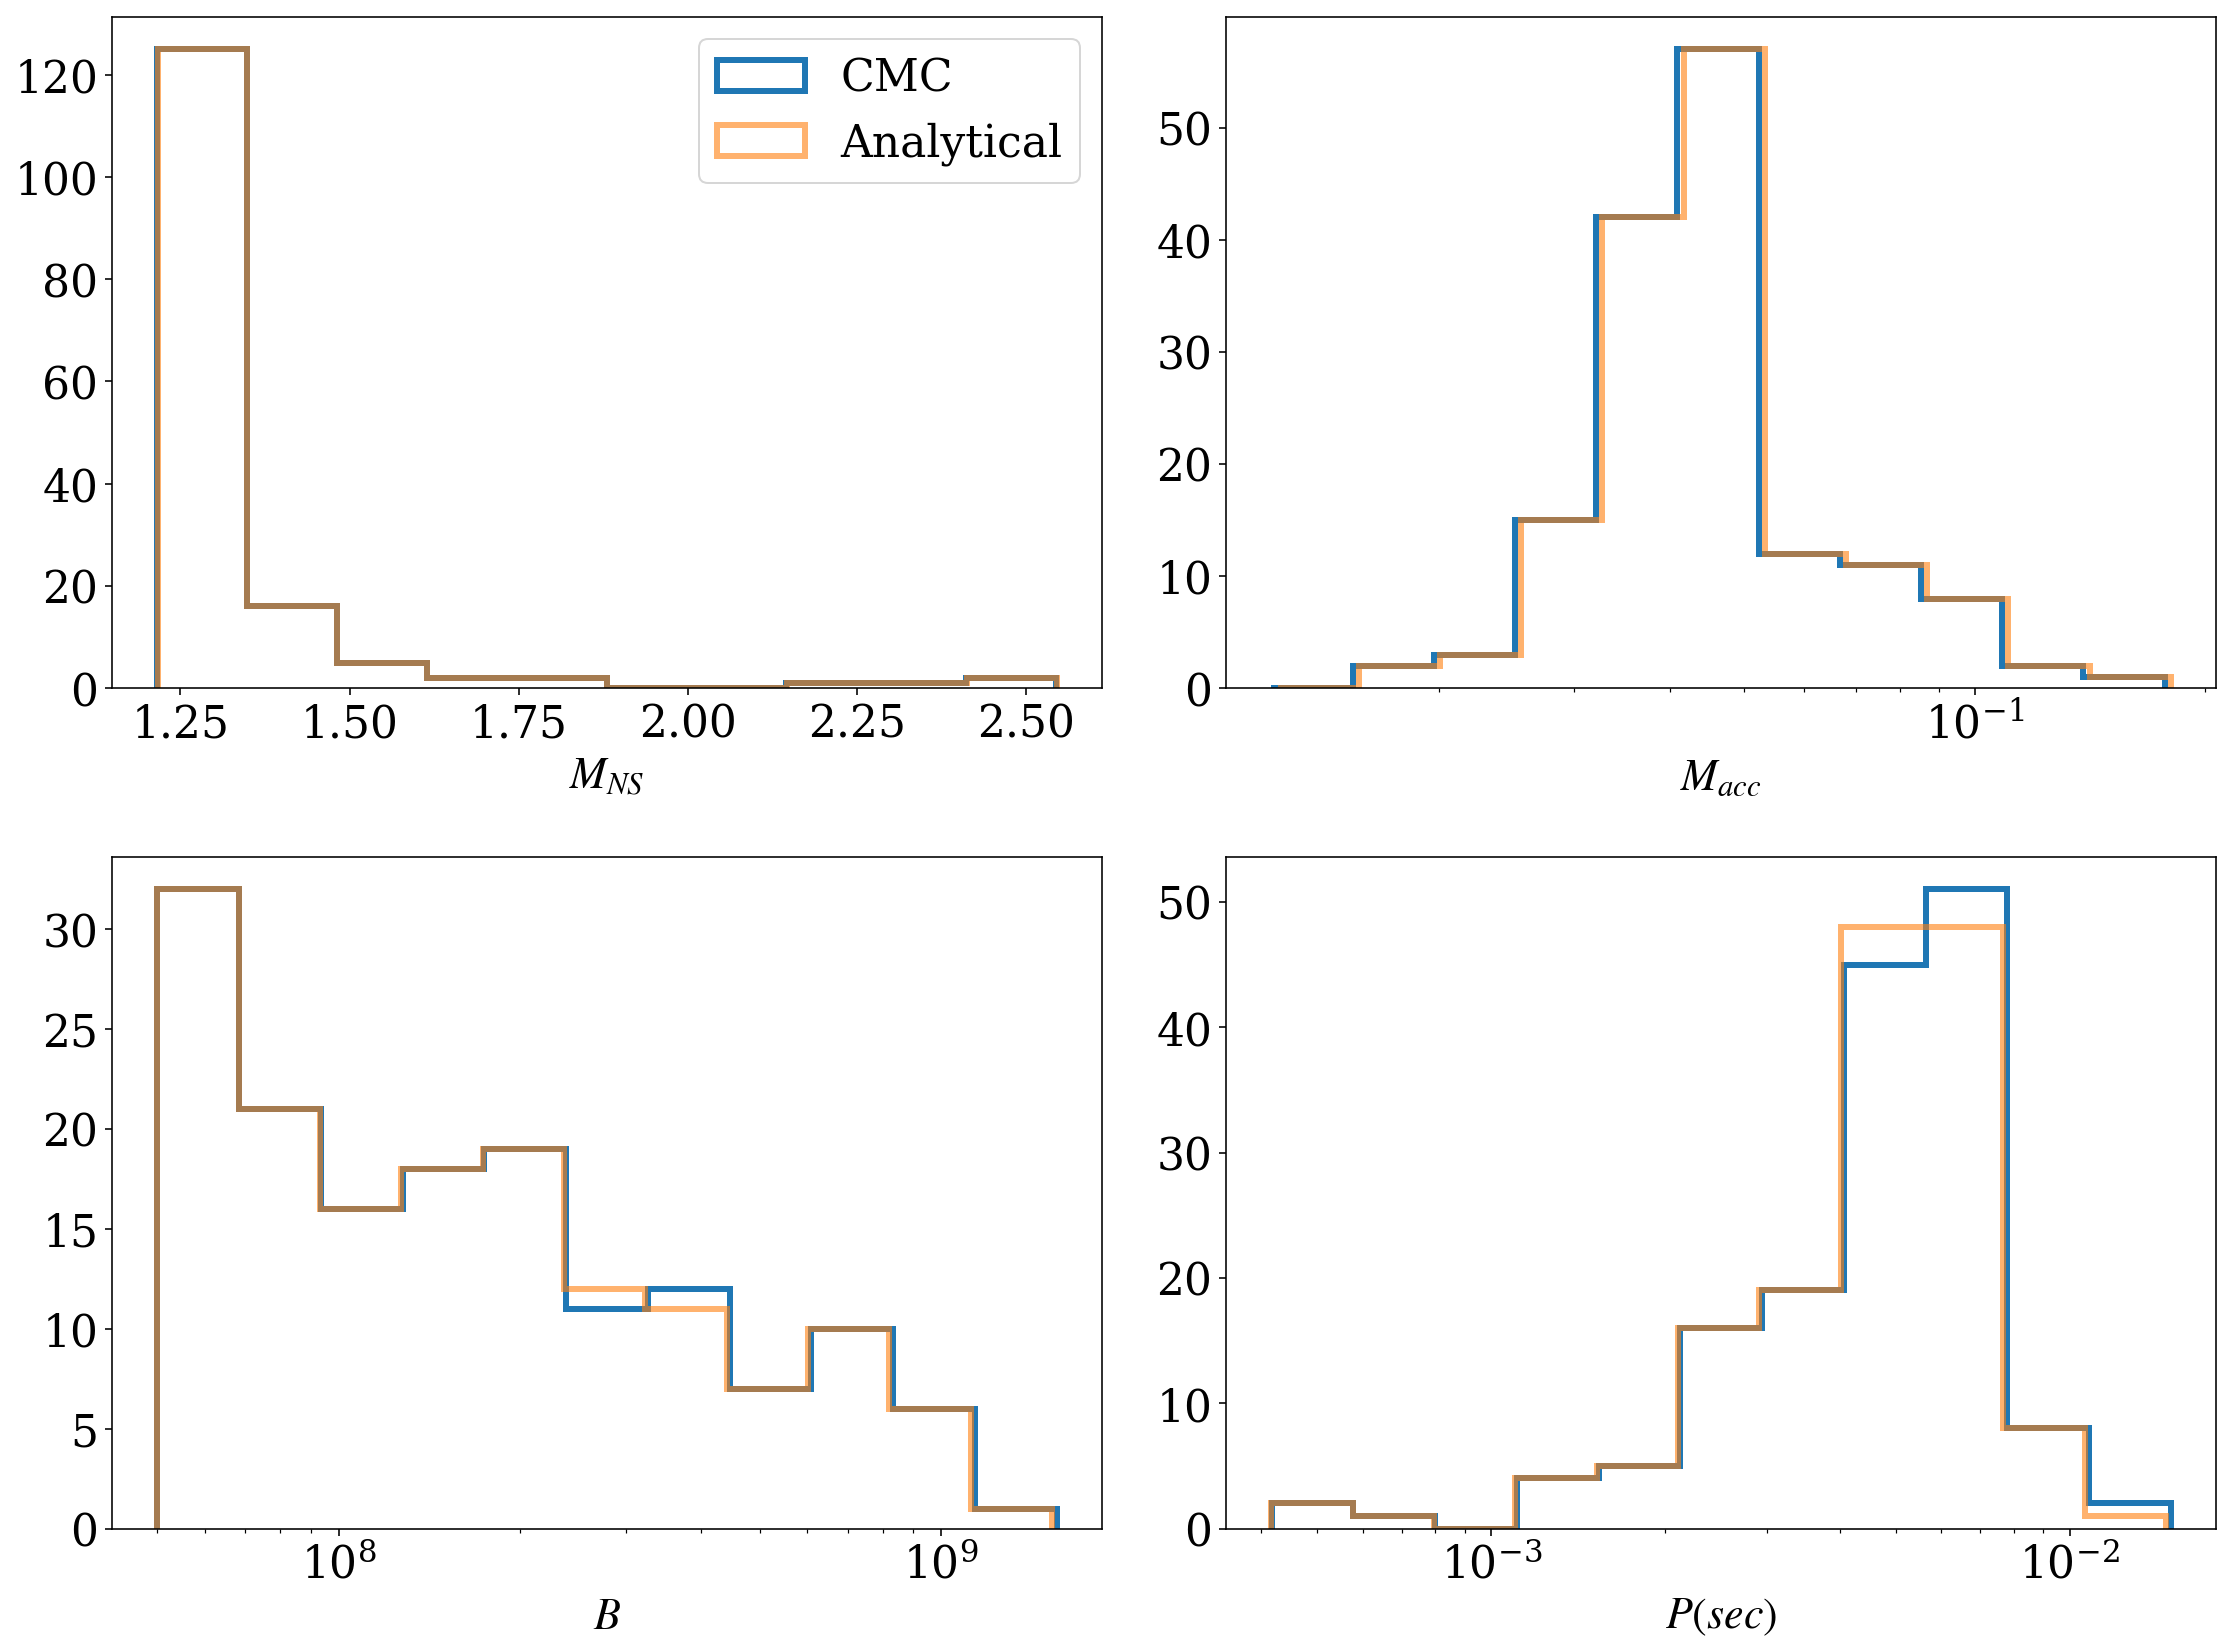

In [9]:
##Check if NS-MS TDE is actually working
error_out = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_nstde_s0.2/error.out'
m_ns = []; B_ns = []; Ospin_ns = []
m_new = []; B_new = []; Ospin_new = []; Macc = []
m_analy = []; B_analy = []; Ospin_analy = []; Macc_analy = []
m_analy_old = []; B_analy_old = []; Ospin_analy_old = []; Macc_analy_old = []
with open(error_out, 'r') as ferr:
    for line in ferr:
        data=line.split()
        if data[0]=='Before':
            m_star = float(data[3].split('=')[1])
            r_star = float(data[4].split('=')[1])
            k_star = float(data[5].split('=')[1])
            m_ns.append(float(data[6].split('=')[1]))
            B_ns.append(float(data[7].split('=')[1]))
            Ospin_ns.append(float(data[8].split('=')[1]))
            ospin_temp, B_temp, Mns_temp, Macc_temp = func_nsms_tde(float(data[6].split('=')[1]), 
                                                                    m_star, r_star, k_star, 
                                                                    float(data[7].split('=')[1]), 
                                                                    float(data[8].split('=')[1]))
            ospin_temp_old, B_temp_old, Mns_temp_old, Macc_temp_old = func_nsms_tde_old(float(data[6].split('=')[1]), 
                                                                    m_star, r_star, k_star, 
                                                                    float(data[7].split('=')[1]), 
                                                                    float(data[8].split('=')[1]))
            m_analy.append(Mns_temp); B_analy.append(B_temp); Ospin_analy.append(ospin_temp)
            Macc_analy.append(Macc_temp)
            m_analy_old.append(Mns_temp_old); B_analy_old.append(B_temp_old); Ospin_analy_old.append(ospin_temp_old)
            Macc_analy_old.append(Macc_temp_old)
        if data[0]=='After':
            m_new.append(float(data[3].split('=')[1]))
            B_new.append(float(data[4].split('=')[1]))
            Ospin_new.append(float(data[5].split('=')[1]))
            Macc.append(float(data[6].split('=')[1]))
            
Psec_new = twopi*yearsc/np.array(Ospin_new)
Psec_analy = twopi*yearsc/np.array(Ospin_analy)
Psec_analy_old = twopi*yearsc/np.array(Ospin_analy_old)
print(len(Psec_analy), len(Psec_analy[Psec_analy<=0.03]))
print(np.any(k_star>1))
            
#import extract_coll_merger as cm
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'
#cm.get_XX_collision([path_old], 0, 1, [13], path_old+'ns', 0)
collfile = np.genfromtxt(path_old+'ns_coll_all.dat')
Mns_old =collfile[:,4]; k0 = collfile[:,10]; k1 = collfile[:,11]
print(len(Mns_old))
index_nsms = []
for ii in range(len(k0)):
    if k0[ii]==0 or k0[ii]==1 or k1[ii]==0 or k1[ii]==1:
        index_nsms.append(ii)
Mnsms = Mns_old[index_nsms]
print(len(Mnsms))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 12))
axs[0][0].hist(m_new, lw=3,
              histtype='step', label = 'CMC')
axs[0][0].hist(m_analy, lw=3,
              histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[0][0].hist(m_analy_old, lw=3,
#              histtype='step', label = 'Analytical Old',
#              alpha=0.6)
#axs[0][0].hist(Mnsms, lw=3, bins = 12,
#              histtype='step', label = 'Old model',
#              alpha=0.6)
axs[0][0].set_xlabel(r'$M_{NS}$')
axs[0][0].legend()

axs[0][1].hist(Macc,
              bins = np.logspace(np.log10(np.min(Macc)), np.log10(np.max(Macc)), 12),
              lw=3,histtype='step', label = 'CMC')
axs[0][1].hist(Macc_analy,
               bins = np.logspace(np.log10(np.min(Macc_analy)), np.log10(np.max(Macc_analy)), 12),
              lw=3,histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[0][1].hist(Macc_analy_old,
#               bins = np.logspace(np.log10(np.min(Macc_analy_old)), np.log10(np.max(Macc_analy_old)), 12),
#              lw=3,histtype='step', label = 'Analytical Old',
#              alpha=0.6)
axs[0][1].set_xlabel(r'$M_{acc}$')
axs[0][1].set_xscale('log')

axs[1][0].hist(B_new, bins = np.logspace(np.log10(np.min(B_new)), np.log10(np.max(B_new)), 12),
              lw=3,histtype='step', label = 'CMC')
axs[1][0].hist(B_analy,bins = np.logspace(np.log10(np.min(B_analy)), np.log10(np.max(B_analy)), 12),
              lw=3,histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[1][0].hist(B_analy_old,bins = np.logspace(np.log10(np.min(B_analy_old)), np.log10(np.max(B_analy_old)), 12),
#              lw=3,histtype='step', label = 'Analytical Old',
#              alpha=0.6)
axs[1][0].set_xscale('log')
axs[1][0].set_xlabel(r'$B$')

axs[1][1].hist(Psec_new,
               bins = np.logspace(np.log10(np.min(Psec_new)), np.log10(np.max(Psec_new)), 12),
              lw=3,histtype='step', label = 'CMC')
axs[1][1].hist(Psec_analy,
               bins = np.logspace(np.log10(np.min(Psec_analy)), np.log10(np.max(Psec_analy)), 12),
              lw=3,histtype='step', label = 'Analytical',
              alpha=0.6)
#axs[1][1].hist(Psec_analy_old,
#               bins = np.logspace(np.log10(np.min(Psec_analy_old)), np.log10(np.max(Psec_analy_old)), 12),
#              lw=3,histtype='step', label = 'Analytical Old',
#              alpha=0.6)
axs[1][1].set_xscale('log')
axs[1][1].set_xlabel(r'$P(sec)$')

fig.tight_layout()

1 TDE0.2 154
2 TDE0.8 110
3 WDTC 0
4 TDE0.2-WDTC 186
5 TDE0.2-WDTC-GCTC 347


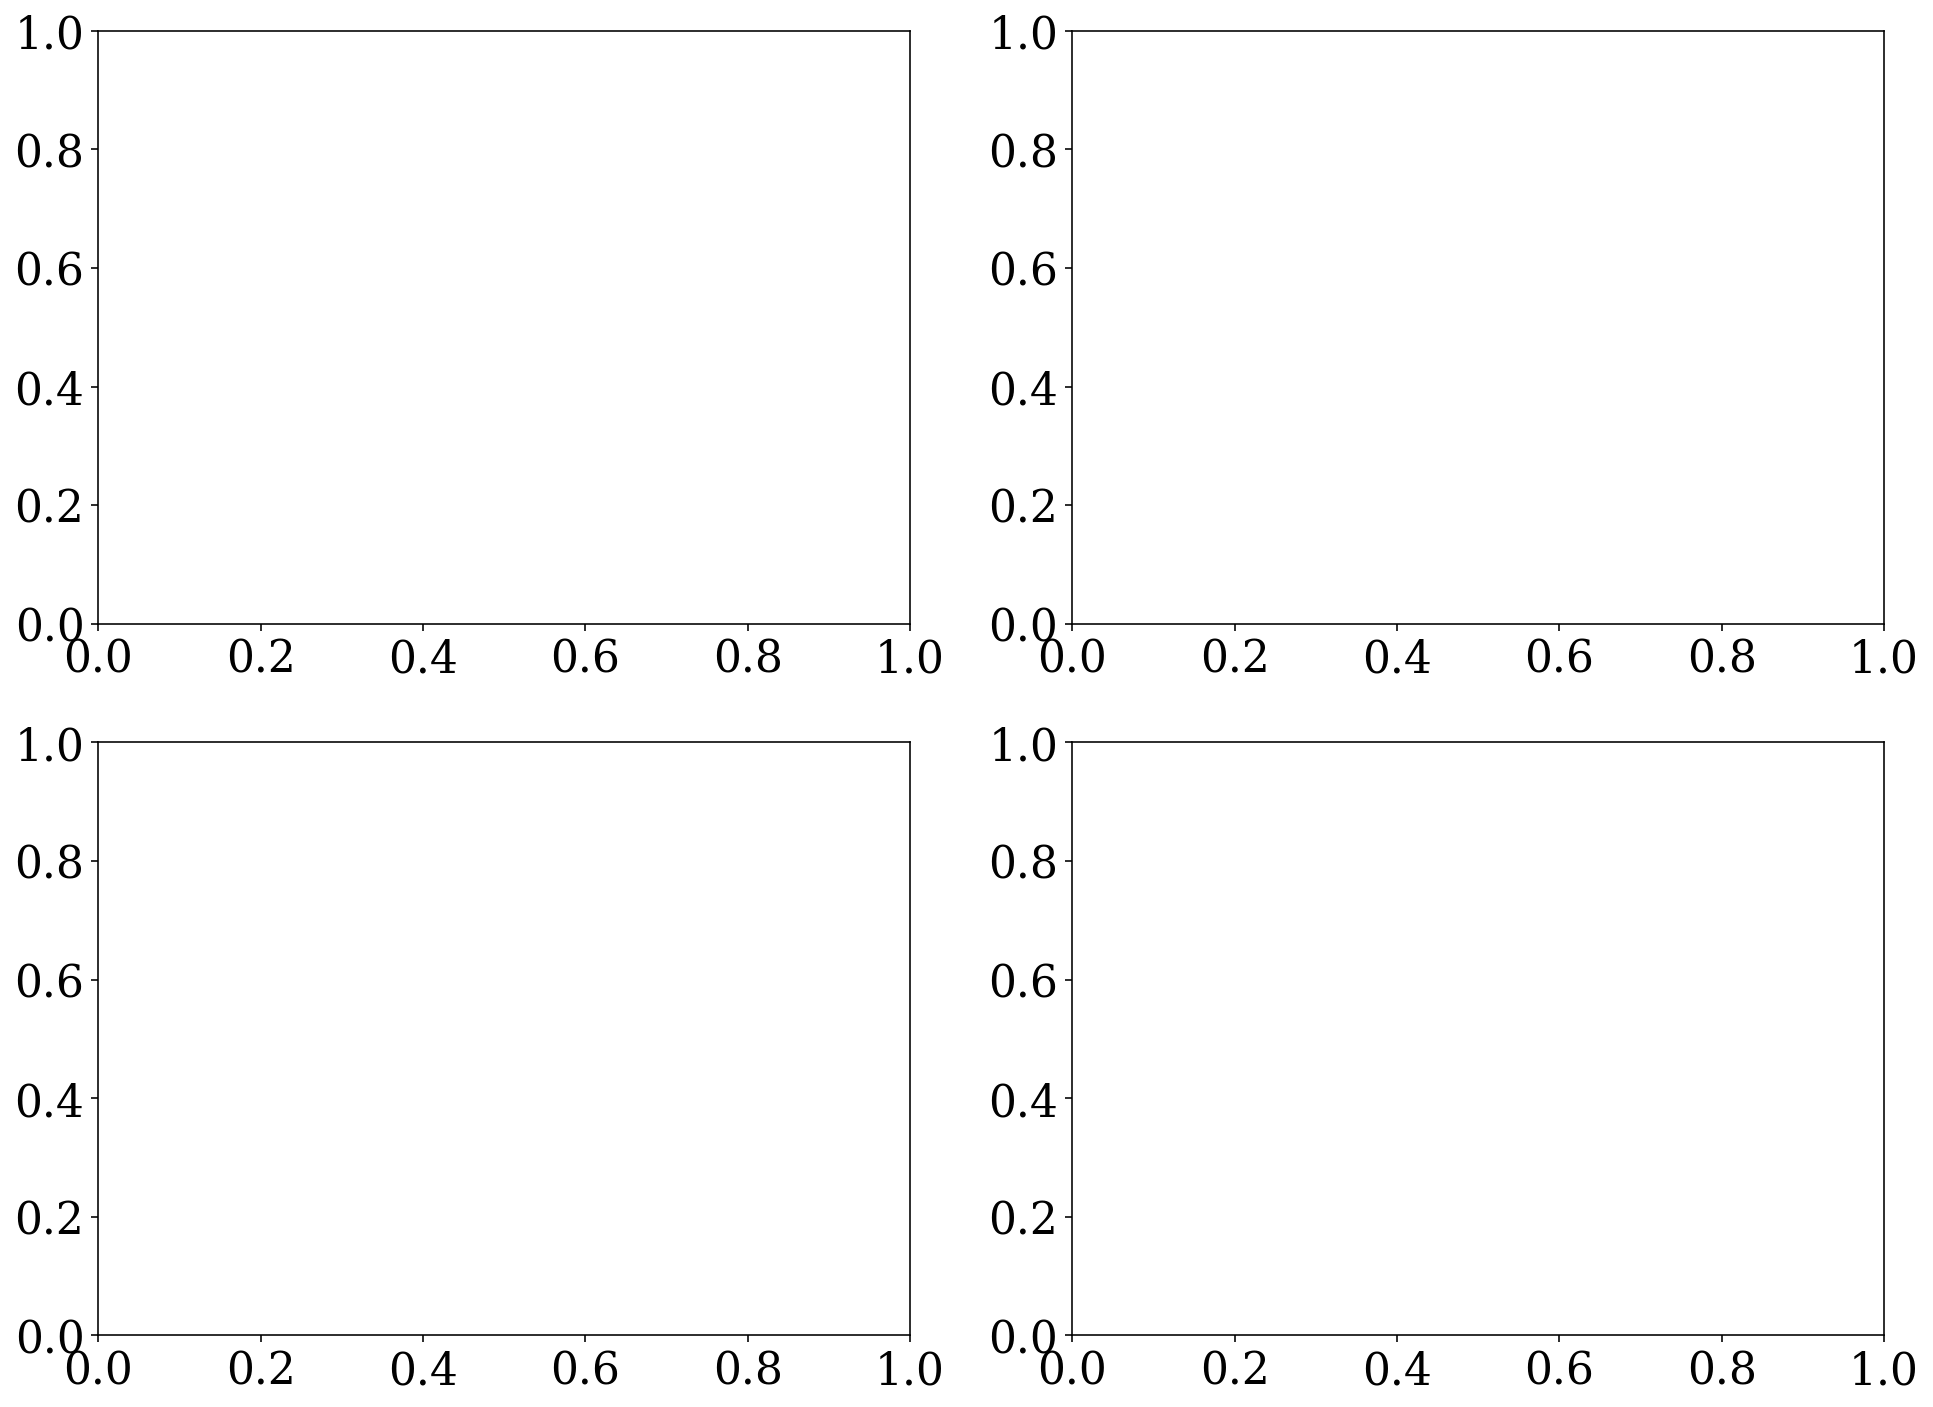

In [7]:
##Number of TDEs in different models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 12))
for xx in range(1,len(paths)):
    error_out = paths[xx]+'error.out'
    m_ns = []; B_ns = []; Ospin_ns = []
    m_new = []; B_new = []; Ospin_new = []; Macc = []
    with open(error_out, 'r') as ferr:
        for line in ferr:
            data=line.split()
            if data[0]=='Before':
                m_star = float(data[3].split('=')[1])
                r_star = float(data[4].split('=')[1])
                k_star = float(data[5].split('=')[1])
                m_ns.append(float(data[6].split('=')[1]))
                B_ns.append(float(data[7].split('=')[1]))
                Ospin_ns.append(float(data[8].split('=')[1]))
                
            if data[0]=='After':
                m_new.append(float(data[3].split('=')[1]))
                B_new.append(float(data[4].split('=')[1]))
                Ospin_new.append(float(data[5].split('=')[1]))
                Macc.append(float(data[6].split('=')[1]))
                
    Psec_new = twopi*yearsc/np.array(Ospin_new)
    
    print(xx, model_label[xx], len(Psec_new))
                
    #axs[0][0].hist(m_new, bins = int(len(Psec_new)/10),
    #               lw=3, histtype='step', label = model_label[xx])
    #
    #axs[0][1].hist(Macc,
    #              bins = np.logspace(np.log10(np.min(Macc)), np.log10(np.max(Macc)), int(len(Psec_new)/10)),
    #              lw=3,histtype='step', label = model_label[xx])
    #
    #axs[1][0].hist(B_new, bins = np.logspace(np.log10(np.min(B_new)), np.log10(np.max(B_new)), int(len(Psec_new)/10)),
    #              lw=3,histtype='step', label = model_label[xx])
    #
    #axs[1][1].hist(Psec_new,
    #               bins = np.logspace(np.log10(np.min(Psec_new)), np.log10(np.max(Psec_new)), int(len(Psec_new)/10)),
    #              lw=3,histtype='step', label = model_label[xx])

    
#axs[0][0].set_xlabel(r'$M_{NS}$')
#axs[0][0].legend()
#
#axs[0][1].set_xlabel(r'$M_{acc}$')
#axs[0][1].set_xscale('log')
#
#axs[1][0].set_xscale('log')
#axs[1][0].set_xlabel(r'$B$')
#
#axs[1][1].set_xscale('log')
#axs[1][1].set_xlabel(r'$P(sec)$')
#    
#fig.tight_layout()

In [7]:
##Check how many TDE happens during binary-mediated interactions
##And whether the NS is initially single annd whether it merge in a binary or isolated
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_ICold_wdmass_nstde_test/'
nscoll = np.genfromtxt(path_new+'ns_coll_all.dat', dtype=str)
Mns_coll =nscoll[:,4]
k0 = [*map(int, nscoll[:,10])]; k1 = [*map(int, nscoll[:,11])]
k2 = [*map(int, nscoll[:,12])]; k3 = [*map(int, nscoll[:,13])]
type_coll=nscoll[:,-1]
print(len(k0))

n_ss = 0; n_nonss = 0
n_tri = 0; n_quad = 0
for kk in range(len(k0)):
    if k3[kk]==-100 and k2[kk]==-100:
        if k0[kk]<=1 or k1[kk]<=1:
            if type_coll[kk]=='SS':
                n_ss+=1
            else:
                n_nonss+=1
    elif k3[kk]==-100:
        if (k0[kk]<=1 or k1[kk]<=1 or k2[kk]<=1):
            n_tri+=1
            if type_coll[kk]=='SS':
                n_ss+=1
            else:
                n_nonss+=1
                
        k_array=np.sort([k0[kk],k1[kk],k2[kk]])
        print(k_array)
        
    else:
        if (k0[kk]<=1 or k1[kk]<=1 or k2[kk]<=1 or k3[kk]<=1):
            n_quad+=1
            if type_coll[kk]=='SS':
                n_ss+=1
            else:
                n_nonss+=1
        k_array=np.sort([k0[kk],k1[kk],k2[kk],k3[kk]])
        print(k_array)

print(n_ss, n_nonss)
print(n_tri,n_quad)         
        


218
[ 6 12 13]
[ 0  1 13]
[ 1 11 13]
[ 1  3 13]
[ 1 11 13]
[ 0 11 13]
[ 0 11 13]
[ 1 12 13]
[ 0  0 13]
[ 6 11 13]
[ 1  1 13]
[ 1 11 13]
[ 1  1  1 13]
[ 4 10 13 13]
[ 1 11 13]
[ 0 11 13]
[ 3 11 13]
[ 1 11 13]
[ 2 10 13]
[ 1 12 13]
[ 0 11 13]
[ 3 11 13]
[ 0  1 13]
[ 0  0 13]
[ 0 12 13]
[ 1 11 13]
[ 0 11 13]
[ 0 13 14]
[ 3 12 13]
[ 0 11 13]
[ 0  0  1 13]
20 160
22 2


In [62]:
##Kicks
def vkick(alpha, Mns, Mstar, Rstar, rratio, Mej):
    rt = (Mns/Mstar)**(1./3.)*Rstar
    rp = rt*rratio
    if rp>rt:
        E_ej = Gconst_sun*Mns*Rstar/rp**2*PC_Rsun-0.5*Gconst_sun*(Mstar-Mej)*PC_Rsun/Rstar
    else:
        E_ej = Gconst_sun*Mns*Rstar/rt**2*PC_Rsun-0.5*Gconst_sun*(Mstar-Mej)*PC_Rsun/Rstar

    v_ej = math.sqrt(2*E_ej)
    v_max = Mej*v_ej/(Mns+Mstar-Mej)

    return v_max**(1-alpha*(Mns/Mstar)**(2/3)*rratio)

rratio_list = [0.5, 0.75, 1.]; Mej_list = [0.253, 0.136, 0.088] #[0.198, 0.353, 0.389] #
for ii in range(len(rratio_list)):
    print(vkick(0.5, 1.2, 1.2, 1.1, rratio_list[ii], Mej_list[ii]))
    

21.325873491937735
8.18724198142156
4.240857022108854


# WD-WD TC; Polypical index check

In [2]:
def R_WD(M_WD):   ##from SSE
    M_ch = 1.44
    R_WD = max(1.4e-5, 0.0115*math.sqrt((M_ch/M_WD)**(2/3)-(M_WD/M_ch)**(2/3)))
    
    return R_WD

print(R_WD(1.36))

def Tl(order, polytropicindex, eta):
    l=order; n=polytropicindex; x=np.log10(eta); x2=x*x; x3=x*x2; x4=x2*x2; x5=x2*x3

    if l != 2 and l != 3:
        print("unknown order")
    
    ##From Portegies Zwart & Meinen 1993
    if n == 1.5:
        if l == 2: 
            return pow(10.0, -0.397 + 1.678*x + 1.277*x2 - 12.42*x3 + 9.446*x4 - 5.550*x5)
        else:
            return pow(10.0, -0.909 + 1.574*x + 12.37*x2 - 57.40*x3 + 80.10*x4 - 46.43*x5)
                
    elif n == 2.0:
        if l == 2:
            return pow(10.0, -0.517 - 0.906*x + 23.88*x2 - 93.49*x3 + 112.3*x4 - 44.15*x5)
        else:
            return pow(10.0, -1.040 - 1.354*x + 37.64*x2 - 139.9*x3 + 168.2*x4 - 66.53*x5)
                
    elif n == 3.0:
        if l == 2:
            return pow(10.0, -1.124 + 0.877*x - 13.37*x2 + 21.55*x3 - 16.48*x4 + 4.124*x5)
        else:
            return pow(10.0, -1.703 + 2.653*x - 14.34*x2 + 12.85*x3 - 0.492*x4 - 3.600*x5)
                
    else:
        printf("unknown polytropic index")
             
        

def E_oscillate(rperi, Mosc, Rosc, nosc, Mpert):
    eta=math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    #rperi = Rosc*pow((Mosc+Mpert)/Mosc,1/3)*pow(eta, 2/3)

    return Gconst_sun*PC_Rsun*Mpert**2/Rosc * (pow(Rosc/rperi, 6.0) * Tl(2, nosc, eta) + pow(Rosc/rperi, 8.0) * Tl(3, nosc, eta))

0.0031751177903183744


-9.81304016231914


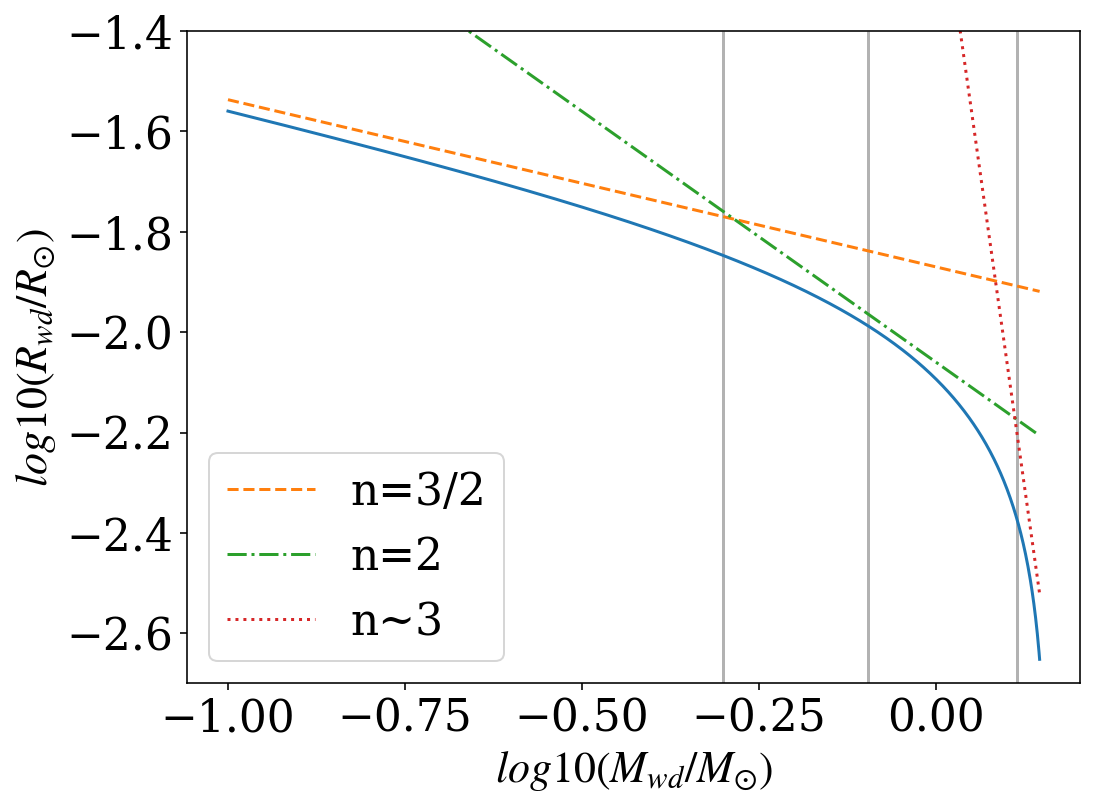

In [19]:
##Finding the mass cutoff for different polytropic index of WDs
mwd = np.linspace(0.1,1.4, 500)
rwd = []; rwd_low = []
for ii in range(len(mwd)):
    rwd.append(R_WD(mwd[ii]))
    rho_ave = mwd[ii]*Msun/(2*twopi/3*(R_WD(mwd[ii])*Rsun)**3)
    #if rho_ave >=1e6:
        #print(mwd[ii])
        
print((np.log10(rwd[499])-np.log10(rwd[470]))/(np.log10(mwd[499])-np.log10(mwd[470])))
        
y0 = np.log10(np.array(mwd)**(-1/3))-1.87
y1 = np.log10(np.array(mwd)**(-1))-2.06
y2 = np.log10(np.array(mwd)**(-10))-1.06

plt.figure(figsize=(8,6))
plt.plot(np.log10(mwd),np.log10(rwd))
plt.plot(np.log10(mwd), y0, ls='--', label='n=3/2')
plt.plot(np.log10(mwd), y1, ls='-.', label='n=2')
plt.plot(np.log10(mwd), y2, ls='dotted', label='n~3')
plt.vlines(math.log10(0.5), -2.7, -1.4, color='gray', alpha=0.6)
plt.vlines(math.log10(0.8), -2.7, -1.4, color='gray', alpha=0.6)
plt.vlines(math.log10(1.3), -2.7, -1.4, color='gray', alpha=0.6)
plt.ylim(ymax = -1.4, ymin= -2.7)
plt.xlabel(r'$log10(M_{wd}/M_{\odot})$')
plt.ylabel(r'$log10(R_{wd}/R_{\odot})$')
plt.legend(loc='best')

[0.021392743474959133, 0.01594811244062899, 0.012778467098439529, 0.010311127424985122, 0.008058157517676339, 0.005677022808780932, 0.0022288464855878044]
[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]


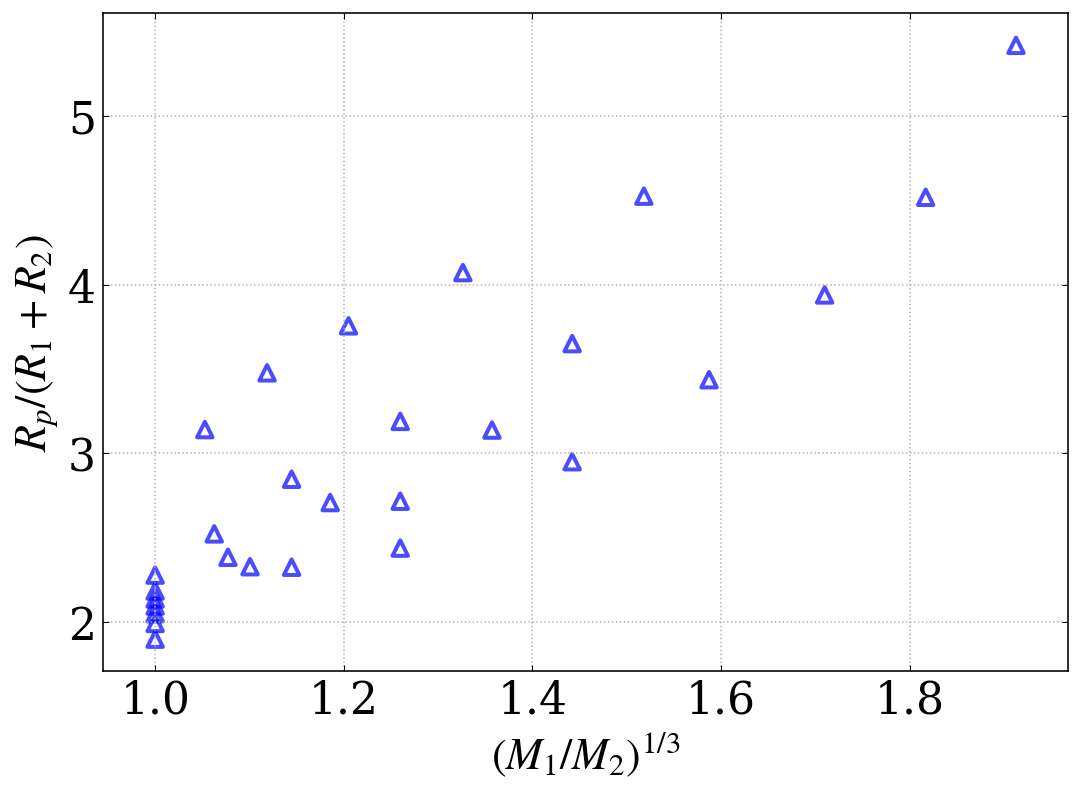

In [4]:
test_range=np.linspace(1,20,200)  ##for pericenter distance in WD radius
vel_disp = [1,10] ##km/s
M_wd = [0.2,0.4,0.6,0.8,1.0,1.2,1.4]
R_wd = [R_WD(M_wd[xx]) for xx in range(len(M_wd))]
n_wd = [[1.5,1.5,2.,2.,2.,2.,2.],[1.5,1.5,1.5,1.5,1.5,1.5,1.5]]
print(R_wd)
#M_pri = [1.3]
#R_pri = [R_WD(M_pri[xx]) for xx in range(len(M_pri))]
#n_pri = [2.]

R_fac = [[[],[]],[[],[]]]
m_ratio = [[[],[]],[[],[]]]
for bb in range(len(vel_disp)):
    for aa in range(2):
        #print(n_wd[aa])
        for ii in range(len(M_wd)):
            for jj in range(ii,len(M_wd)):
            #for jj in range(len(M_pri)):
                #E_kin = 0.5*M_wd[ii]*M_pri[jj]/(M_wd[ii]+M_pri[jj])*vel_disp[bb]**2
                E_kin = 0.5*M_wd[ii]*M_wd[jj]/(M_wd[ii]+M_wd[jj])*vel_disp[bb]**2
                #f = lambda x: E_oscillate(x*(R_wd[ii]+R_pri[jj]), M_wd[ii], R_wd[ii], n_wd[aa][ii], M_pri[jj])+E_oscillate(x*(R_wd[ii]+R_pri[jj]), M_pri[jj], R_pri[jj], n_pri[jj], M_wd[ii]) - E_kin
                f = lambda x: E_oscillate(x*(R_wd[ii]+R_wd[jj]), M_wd[ii], R_wd[ii], n_wd[aa][ii], M_wd[jj])+E_oscillate(x*(R_wd[ii]+R_wd[jj]), M_wd[jj], R_wd[jj], n_wd[aa][jj], M_wd[ii]) - E_kin

                root_range=[]
                root_range2=[]
                for yy in range(len(test_range)-1):
                    if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                        root_range.append(test_range[yy])
                        root_range.append(test_range[yy+1])
                        
                    if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                        root_range2.append(test_range[yy])
                        root_range2.append(test_range[yy+1])
                
                #print(root_range)
                #print(root_range2)
                if len(root_range)>2 or len(root_range2)>2:
                    print('more than 1 root')
                                              
                real_root = bisect(f, root_range[0],root_range[1])
                R_fac[bb][aa].append(real_root)
                #m_ratio[bb][aa].append(M_pri[jj]/M_wd[ii])
                m_ratio[bb][aa].append(M_wd[jj]/M_wd[ii])
                #print(M_wd[ii],M_pri[jj],real_root)
                #print(M_wd[ii],M_wd[jj],real_root)
    
cs=['orange','b']
mfmt = ['o','^']
#plt.figure(figsize=(8,6))
#plt.hist(R_fac[0], bins=12, histtype='step', 
#         lw=3, alpha=0.6, color='k')
#plt.hist(R_fac[1], bins=12, histtype='step', 
#         lw=3, alpha=0.8, color='gold')
##plt.vlines(np.mean(R_fac[0]),0,8, linestyle='--',color='k')
#plt.vlines(np.median(R_fac[0]),0,8, linestyle='-.',color='k')
##plt.vlines(np.mean(R_fac[1]),0,8, linestyle='--',color='gold')
#plt.vlines(np.median(R_fac[1]),0,8, linestyle='-.',color='gold')
#plt.xlabel(r'$R_{tidal}/R_{wd}$')

plt.figure(figsize=(8,6))
for xx in range(1,len(vel_disp)):
    for yy in range(1,2):
        print(n_wd[yy])
        plt.scatter(np.array(m_ratio[xx][yy])**(1/3),R_fac[xx][yy], 
                    color = cs[xx], marker=mfmt[yy], 
                    facecolor='none', s=60, alpha=0.7, lw=2)
plt.xlabel(r'$(M_1/M_2)^{1/3}$')
plt.ylabel(r'$R_p/(R_1+R_2)$')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')
plt.tight_layout()
plt.savefig(savepath+'crosssect_mratio.pdf', dpi=300)

In [11]:
##Estimate the inspiral time of a WD binary formed in tidal capture
M_wd = [0.6, 1.3]; R_wd = [R_WD(M_wd[xx]) for xx in range(len(M_wd))]
ecc=0.99

for ii in range(len(M_wd)):
    for jj in range(ii,len(M_wd)):
        r_cap_au = 3*(R_wd[ii]+R_wd[jj])/AU_Rsun
        sma_au = r_cap_au/(1-ecc)
        t_tmp = lisa_calc.inspiral_time_peters(sma_au,ecc,M_wd[ii],M_wd[jj])  ##in Gyr
        print(M_wd[ii], M_wd[jj], t_tmp*1e9)

0.6 0.6 2006590.9536334225
0.6 1.3 115239.48697285765
1.3 1.3 2410.3547231010652


# WD Mass Change Check

nsform=0 173
ns_wdwd: 125
0 30
1 4948
2 1307
3 1
4 11
5 2
6 0
7 0
mic? [0 0]
aic? 12 720617 1.24229 1.38022 4
aic? 12 290302 1.24201 1.31586 4
aic? 12 838854 1.24212 1.23942 0
aic? 12 399687 1.24201 1.38001 0
aic? 12 0 1.24209 1.37244 4
aic? 12 153712 1.242 1.37942 4
aic? 12 493490 1.244 1.3434 0
aic? 12 0 1.24223 1.33531 4
aic? 12 574762 1.24976 1.24564 0
aic? 12 751061 1.24636 1.32785 0
aic? 12 654426 1.24244 1.28907 4
aic? 12 628978 1.24241 1.37939 4
aic? 12 723041 1.24216 1.35603 4
aic? 12 635447 1.242 1.37389 0
aic? 12 1135806 1.24221 1.36375 0
aic? 12 284714 1.24255 1.33545 4
aic? 12 0 1.19322 2.077 2
aic? 12 617574 1.24215 1.3335 0
aic? 12 78328 1.24267 1.29965 4
aic? 12 768306 1.24219 1.38002 0
aic? 12 767767 1.2429 1.38001 4
all_nscoll 148
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
18


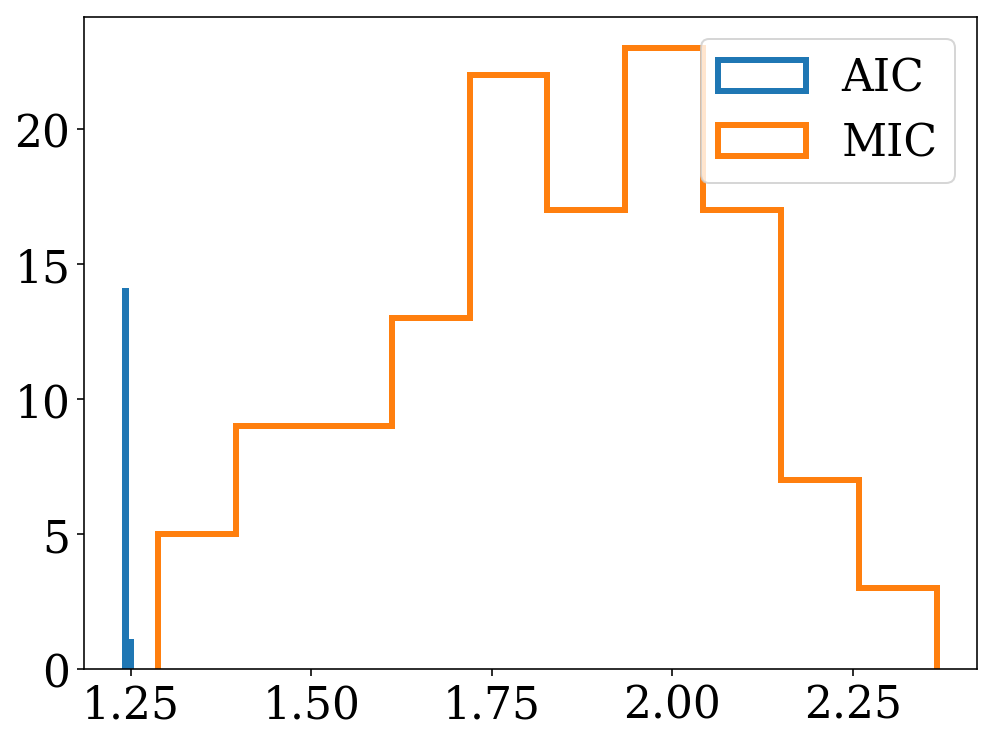

In [4]:
## Check the mass of WD turned NSs and how they are formed
path_test = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.8-rg8-z0.0002_iccatalog_micwd_newnsfile_dynwdmt_wdmass/'
nsform = np.genfromtxt(path_test+'initial.nsformation.dat')
idns = nsform[:,3].astype(np.int); massprev = nsform[:,5]
massns = nsform[:,6]; kprev = nsform[:,9].astype(np.int)
sntype = nsform[:,7].astype(np.int)
print('nsform=0', len(idns[idns==0]))
#print('nsform', len(idns[idns>839961]))
#print('kprev', len(kprev[kprev==12]))
#print('kprev', len(kprev[kprev==11]))
#print('kprev', len(kprev[kprev==10]))

wdwd_coll_file = np.genfromtxt(path_test+'ns_wdwd_coll.dat')
id_coll = wdwd_coll_file[:,2].astype(np.int)
m_coll = wdwd_coll_file[:,4]
print('ns_wdwd:', len(id_coll))


all_nscoll_file = np.genfromtxt(path_test+'ns_collproduct_all.dat')
id_nscoll = all_nscoll_file[:,2].astype(np.int)
m_nscoll = all_nscoll_file[:,4]
k0 = all_nscoll_file[:,10].astype(np.int)
k1 = all_nscoll_file[:,11].astype(np.int)
k2 = all_nscoll_file[:,12].astype(np.int)
k3 = all_nscoll_file[:,13].astype(np.int)


##Analysis
for ii in range(8):
    print(ii, len(sntype[sntype==ii]))
print('mic?', idns[sntype==5])
        

for xx in range(len(idns)):
    if 10<=kprev[xx]<=12:
        print('aic?',kprev[xx], idns[xx], massns[xx], massprev[xx], sntype[xx])
        
        #if idns[xx] in id_coll:
        #    print('yes')
        #else:
        #    print('no')
        
    #if idns[xx]==0:
    #    print('id=0', kprev[xx], idns[xx], massns[xx], massprev[xx], sntype[xx])
    #if massprev[xx]<=2.88:
    #    print(kprev[xx], idns[xx], massns[xx], massprev[xx], sntype[xx])
        
        


index_ns = []
for ii in range(len(k0)):
    if k0[ii]==13 or k1[ii]==13 or k2[ii]==13 or k3[ii]==13:
        index_ns.append(ii)
print('all_nscoll', len(np.delete(id_nscoll, index_ns)))


m_aic = []; m_mic = []
for xx in range(len(idns)):
    if 10<= kprev[xx] <=12:
        print(kprev[xx])
        if idns[xx] not in id_coll:
            m_aic.append(massns[xx])
                   
print(len(m_aic))

m_mic = m_coll
plt.figure(figsize = (8,6))
plt.hist(m_aic, histtype = 'step',
         lw = 3, label='AIC')
plt.hist(m_mic, histtype = 'step',
         lw = 3, label='MIC')
plt.legend()

250
914


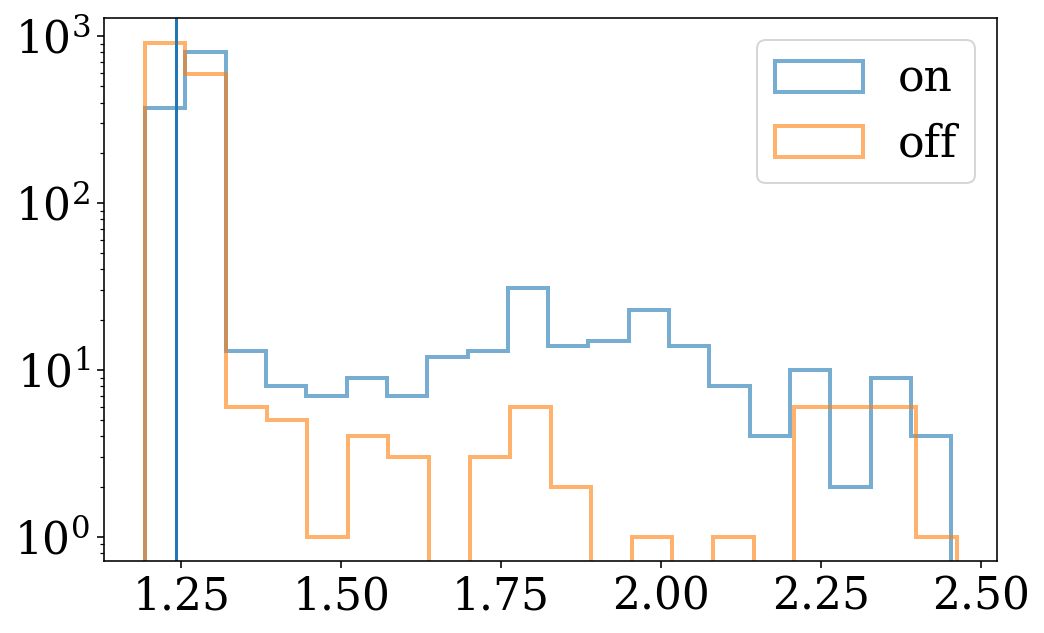

In [2]:
##Check how removing the WD mass limit affect AIC
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.8-rg8-z0.0002_iccatalog_micwd_newnsfile_dynwdmt_wdmass/'
psrfile = path+'initial.morepulsars.dat'
path_off = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_wdtc/'
psrfile_off = path_off+'initial.morepulsars.dat'

t_conv = dyn.conv('t', path+'initial.conv.sh')
t_conv_off = dyn.conv('t', path_off+'initial.conv.sh')

allid = []; tform = []; mform = []
with open(psrfile, 'r') as fpsr:
    next(fpsr)
    for line in fpsr:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid:
                allid.append(int(data[3]))
                tform.append(float(data[1])*t_conv)
                mform.append(float(data[5]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid:
                    allid.append(int(data[3]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[5]))
            if int(data[12])==13:
                if int(data[4]) not in allid:
                    allid.append(int(data[4]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[6]))

mform = np.array(mform)
print(len(mform[mform<1.245]))

allid_off = []; tform_off = []; mform_off = []
with open(psrfile_off, 'r') as fpsr_off:
    next(fpsr_off)
    for line in fpsr_off:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid_off:
                allid_off.append(int(data[3]))
                tform_off.append(float(data[1])*t_conv_off)
                mform_off.append(float(data[5]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid_off:
                    allid_off.append(int(data[3]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[5]))
            if int(data[12])==13:
                if int(data[4]) not in allid_off:
                    allid_off.append(int(data[4]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[6]))
                    
mform_off = np.array(mform_off)
print(len(mform_off[mform_off<1.245]))

#snap_h5 = 'initial.snapshots.h5'
#snap_last = cmct.Snapshot(fname=path+snap_h5, snapshot_name='/423(t=19.263837)', conv=path+'initial.conv.sh')
#binflag = np.array(snap_last.data['binflag'])
#id0 = np.array(snap_last.data['id0'])[binflag==1]; id1 = np.array(snap_last.data['id1'])[binflag==1]
#ids = np.array(snap_last.data['id'])[binflag!=1]
#formation = np.array(snap_last.data['formation'])[binflag!=1]
#formation0 = np.array(snap_last.data['formation0'])[binflag==1]; formation1 = np.array(snap_last.data['formation1'])[binflag==1]
#print(ids)
#print(allid)
#print(len(formation), len(formation[formation==11]))
#
#snform = np.zeros(len(mform))
#for ii in range(len(allid)):
#    for xx in range(len(ids)):
#        if ids[xx]==allid[ii]:
#            snform[ii]==formation[xx]
#            break
#    for yy in range(len(id0)):
#        if id0[yy]==allid[ii]:
#            snform[ii]==formation0[yy]
#            break
#    for zz in range(len(id1)):
#        if id1[zz]==allid[ii]:
#            snform[ii]==formation1[zz]
#
#print(mform[snform==4], len(print(mform[snform==4])))
            
plt.figure(figsize=(8,5))
plt.hist(mform, bins = 20, label='on',
         histtype='step', lw=2, alpha=0.6)
         #bins=np.logspace(np.log10(np.min(mform)), np.log10(np.max(mform)), 20))
plt.hist(mform_off, bins = 20, label='off',
         histtype='step', lw=2, alpha=0.6)
plt.axvline(x=1.242)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

220
Counter({2: 1010, 0: 234, 1: 85, 5: 41, 4: 9})
908
Counter({2: 1217, 0: 247, 1: 85, 4: 11, 3: 1})


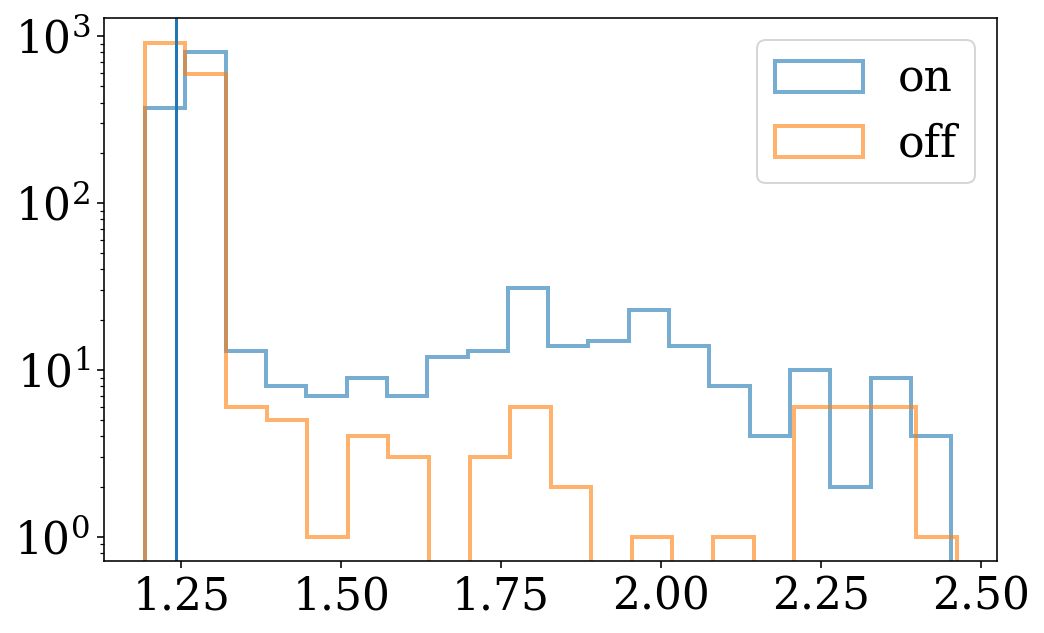

In [3]:
##Check if the wd mass lim is working
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.8-rg8-z0.0002_iccatalog_micwd_newnsfile_dynwdmt_wdmass/'
psrfile = path+'initial.morepulsars.dat'
path_off = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/n8-rv0.5-rg8-z0.0002_iccatalog_wdtc/'
psrfile_off = path_off+'initial.morepulsars.dat'

t_conv = dyn.conv('t', path+'initial.conv.sh')
t_conv_off = dyn.conv('t', path_off+'initial.conv.sh')

allid = []; tform = []; mform = []
snform = []
with open(psrfile, 'r') as fpsr:
    next(fpsr)
    for line in fpsr:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid:
                allid.append(int(data[3]))
                tform.append(float(data[1])*t_conv)
                mform.append(float(data[5]))
                snform.append(int(data[26]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid:
                    allid.append(int(data[3]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[5]))
                    snform.append(int(data[26]))
            if int(data[12])==13:
                if int(data[4]) not in allid:
                    allid.append(int(data[4]))
                    tform.append(float(data[1])*t_conv)
                    mform.append(float(data[6]))
                    snform.append(int(data[27]))

mform = np.array(mform)
print(len(mform[mform<=1.242]))
print(Counter(snform))

allid_off = []; tform_off = []; mform_off = []
snform_off = []
with open(psrfile_off, 'r') as fpsr_off:
    next(fpsr_off)
    for line in fpsr_off:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid_off:
                allid_off.append(int(data[3]))
                tform_off.append(float(data[1])*t_conv_off)
                mform_off.append(float(data[5]))
                snform_off.append(int(data[26]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid_off:
                    allid_off.append(int(data[3]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[5]))
                    snform_off.append(int(data[26]))
            if int(data[12])==13:
                if int(data[4]) not in allid_off:
                    allid_off.append(int(data[4]))
                    tform_off.append(float(data[1])*t_conv_off)
                    mform_off.append(float(data[6]))
                    snform_off.append(int(data[27]))
                    
mform_off = np.array(mform_off)
print(len(mform_off[mform_off<=1.242]))
print(Counter(snform_off))

#snap_h5 = 'initial.snapshots.h5'
#snap_last = cmct.Snapshot(fname=path+snap_h5, snapshot_name='/423(t=19.263837)', conv=path+'initial.conv.sh')
#binflag = np.array(snap_last.data['binflag'])
#id0 = np.array(snap_last.data['id0'])[binflag==1]; id1 = np.array(snap_last.data['id1'])[binflag==1]
#ids = np.array(snap_last.data['id'])[binflag!=1]
#formation = np.array(snap_last.data['formation'])[binflag!=1]
#formation0 = np.array(snap_last.data['formation0'])[binflag==1]; formation1 = np.array(snap_last.data['formation1'])[binflag==1]
#print(ids)
#print(allid)
#print(len(formation), len(formation[formation==11]))
#
#snform = np.zeros(len(mform))
#for ii in range(len(allid)):
#    for xx in range(len(ids)):
#        if ids[xx]==allid[ii]:
#            snform[ii]==formation[xx]
#            break
#    for yy in range(len(id0)):
#        if id0[yy]==allid[ii]:
#            snform[ii]==formation0[yy]
#            break
#    for zz in range(len(id1)):
#        if id1[zz]==allid[ii]:
#            snform[ii]==formation1[zz]
#
#print(mform[snform==4], len(print(mform[snform==4])))
            
plt.figure(figsize=(8,5))
plt.hist(mform, bins = 20, label='on',
         histtype='step', lw=2, alpha=0.6)
         #bins=np.logspace(np.log10(np.min(mform)), np.log10(np.max(mform)), 20))
plt.hist(mform_off, bins = 20, label='off',
         histtype='step', lw=2, alpha=0.6)
plt.axvline(x=1.242)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

220
Counter({2: 1010, 0: 234, 1: 85, 5: 41, 4: 9})
720617 [720617] [12] [1.25261607]
153712 [153712] [12] [1.37942444]
628978 [628978] [11] [1.17536156]
654426 [654426] [12] [1.28922845]
723041 [723041] [12] [1.315261]
284714 [284714] [12] [1.33545212]
78328 [78328] [12] [1.29965371]
918290 couldn't find
767767 [767767] [12] [1.35410483]
[1032362 1207392 1172522  957379 1019200 1035439 1040313 1065723]
ejected 875664
ejected 958086
ejected 1110801
ejected 915867
ejected 1126896
ejected 1189996
ejected 919039
ejected 1021037
[221252, 542907, 376676, 1241685, 812243, 831636, 1196852, 839524, 835542, 820905, 804604, 826691, 827875, 826315, 807364, 836917, 801380, 805758, 832713, 805109, 803457, 806120, 820673, 836569, 819105, 828368, 818138, 826906, 829118, 823444, 814322, 838854, 399687, 1282286, 493490, 1382776, 574762, 751061, 941888, 635447, 1061213, 872867, 957148, 1262219, 1250534, 1424735, 1061215, 1093284, 993852, 1135806, 1068964, 1174261, 916790, 967702, 867438, 992371, 1342342,

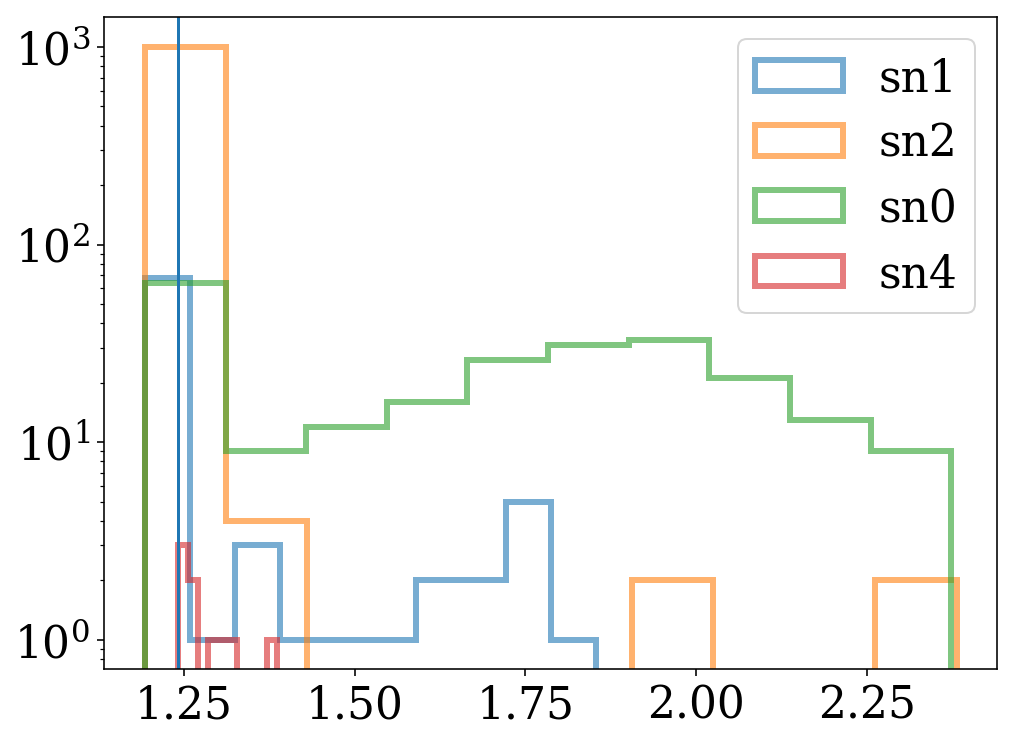

In [5]:
##Check AIC and WD-WD merger (not collisions)
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.8-rg8-z0.0002_iccatalog_micwd_newnsfile_dynwdmt_wdmass/'
psrfile = path+'initial.morepulsars.dat'
collfile = np.genfromtxt(path+'ns_wdwd_coll.dat')
idcoll = collfile[:,2].astype(np.int)

snap_h5 = 'initial.snapshots.h5'

t_conv = dyn.conv('t', path+'initial.conv.sh')

snapkeys = np.genfromtxt(path+'snap_keys.txt', dtype=str)
snpno = snapkeys[:,0]; snptime = snapkeys[:,1]
snptime_float = snptime.astype(np.float)

allid = []; tform = []; mform = []
snform = []
with open(psrfile, 'r') as fpsr:
    next(fpsr)
    for line in fpsr:
        data = line.split()
        if int(data[2])!=1:
            if int(data[3]) not in allid:
                allid.append(int(data[3]))
                tform.append(float(data[1]))#*t_conv)
                mform.append(float(data[5]))
                snform.append(int(data[26]))
                
        else:
            if int(data[11])==13:
                if int(data[3]) not in allid:
                    allid.append(int(data[3]))
                    tform.append(float(data[1]))#*t_conv)
                    mform.append(float(data[5]))
                    snform.append(int(data[26]))
            if int(data[12])==13:
                if int(data[4]) not in allid:
                    allid.append(int(data[4]))
                    tform.append(float(data[1]))#*t_conv)
                    mform.append(float(data[6]))
                    snform.append(int(data[27]))

mform = np.array(mform)
snform = np.array(snform)
allid = np.array(allid)
tform = np.array(tform)
print(len(mform[mform<=1.242]))
print(Counter(snform))


idsn4 = allid[snform==4]
tsn4 = tform[snform==4]
for xx in range(len(idsn4)):
    check_ind = np.where(snptime_float>tsn4[xx])[0][0]-1
    #print(check_ind)
    snpkey = '/'+snpno[check_ind]+'(t='+snptime[check_ind]+')'
    snap = cmct.Snapshot(fname=path+snap_h5, snapshot_name=snpkey, conv=path+'initial.conv.sh')
    binflag = np.array(snap.data['binflag'])
    id0 = np.array(snap.data['id0'])[binflag==1]; id1 = np.array(snap.data['id1'])[binflag==1]
    ids = np.array(snap.data['id'])[binflag!=1]
    ktype = np.array(snap.data['startype'])[binflag!=1]
    k0 = np.array(snap.data['bin_startype0'])[binflag==1]
    k1 = np.array(snap.data['bin_startype1'])[binflag==1]
    mstar = np.array(snap.data['m_MSUN'])[binflag!=1]
    m0 = np.array(snap.data['m0_MSUN'])[binflag==1]
    m1 = np.array(snap.data['m1_MSUN'])[binflag==1]
    if idsn4[xx] in ids:
        print(idsn4[xx], ids[ids==idsn4[xx]], ktype[ids==idsn4[xx]], mstar[ids==idsn4[xx]])
    elif idsn4[xx] in id0:
        print(idsn4[xx], id0[id0==idsn4[xx]], k0[id0==idsn4[xx]], m0[id0==idsn4[xx]])
    elif idsn4[xx] in id1:
        print(idsn4[xx], id1[id1==idsn4[xx]], k1[id1==idsn4[xx]], m1[id1==idsn4[xx]])
    else:
        print(idsn4[xx], "couldn't find")
        
idsn2 = allid[snform==2]
msn2 = mform[snform==2]
print(idsn2[msn2>1.3])

idsn0 = allid[snform==0]
msn0 = mform[snform==0]
ncoll = 0
idsn0_notcoll = []
for xx in range(len(idcoll)):
    if idcoll[xx] in idsn0:
        ncoll+=1
    else:
        print('ejected', idcoll[xx])   
        
for xx in range(len(idsn0)):
    if idsn0[xx] not in idcoll:
        idsn0_notcoll.append(idsn0[xx])
        
print(idsn0_notcoll)
print(ncoll)

idspec = 815027
tspec = 0.13651785
indspec = np.where(snptime_float>tspec)[0][0]-2
snpkey = '/'+snpno[indspec]+'(t='+snptime[indspec]+')'
snap = cmct.Snapshot(fname=path+snap_h5, snapshot_name=snpkey, conv=path+'initial.conv.sh')
binflag = np.array(snap.data['binflag'])
id0 = np.array(snap.data['id0'])[binflag==1]; id1 = np.array(snap.data['id1'])[binflag==1]
ids = np.array(snap.data['id'])[binflag!=1]
ktype = np.array(snap.data['startype'])[binflag!=1]
k0 = np.array(snap.data['bin_startype0'])[binflag==1]
k1 = np.array(snap.data['bin_startype1'])[binflag==1]
mstar = np.array(snap.data['m_MSUN'])[binflag!=1]
m0 = np.array(snap.data['m0_MSUN'])[binflag==1]
m1 = np.array(snap.data['m1_MSUN'])[binflag==1]
if idspec in ids:
    print(idspec, ids[ids==idspec], ktype[ids==idspec], mstar[ids==idspec])
elif idspec in id0:
    print(idspec, id0[id0==idspec], k0[id0==idspec], m0[id0==idspec])
elif idspec in id1:
    print(idspec, id1[id1==idspec], k1[id1==idspec], m1[id1==idspec])
else:
    print(idspec, "couldn't find")


plt.figure(figsize=(8,6))
#plt.hist(mform, histtype='step', lw=3, alpha=0.6)
plt.hist(mform[snform==1], histtype='step', lw=3, alpha=0.6, label='sn1')
plt.hist(mform[snform==2], histtype='step', lw=3, alpha=0.6, label='sn2')
plt.hist(mform[snform==0], histtype='step', lw=3, alpha=0.6, label='sn0')
plt.hist(mform[snform==4], histtype='step', lw=3, alpha=0.6, label='sn4')
plt.axvline(x=1.242)
plt.yscale('log')
plt.legend()

False


(array([ 5.,  9.,  9., 13., 22., 17., 23., 17.,  7.,  3.]),
 array([1.2879873 , 1.39578867, 1.50359004, 1.61139141, 1.71919278,
        1.82699415, 1.93479552, 2.04259689, 2.15039826, 2.25819963,
        2.366001  ]),
 <a list of 1 Patch objects>)

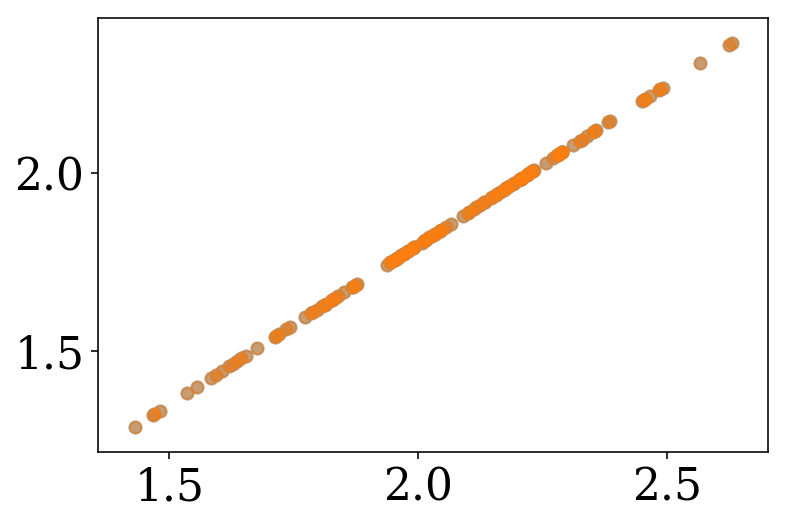

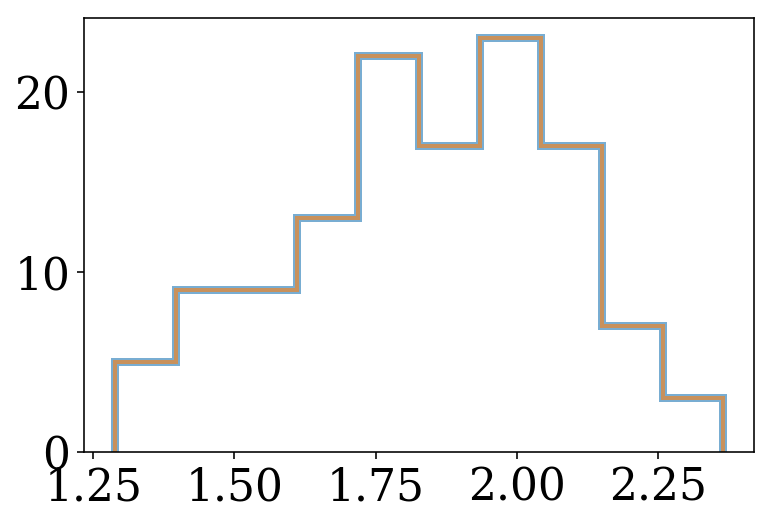

In [6]:
##WD merger and collison to NS
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.8-rg8-z0.0002_iccatalog_micwd_newnsfile_dynwdmt_wdmass/'
collfile = np.genfromtxt(path+'ns_wdwd_coll.dat')
Mcoll = collfile[:,4]; M0 = collfile[:,5]; M1 = collfile[:,6]
Mns = 0.9*(M0+M1)

print(np.any(Mcoll<=1.242))

plt.figure()
plt.scatter(M0+M1, Mcoll, alpha=0.5)
plt.scatter(M0+M1, Mns, alpha=0.5)

plt.figure()
plt.hist(Mcoll, histtype='step', lw=4, alpha=0.6)
plt.hist(Mns, histtype='step', lw=2, alpha=0.6)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


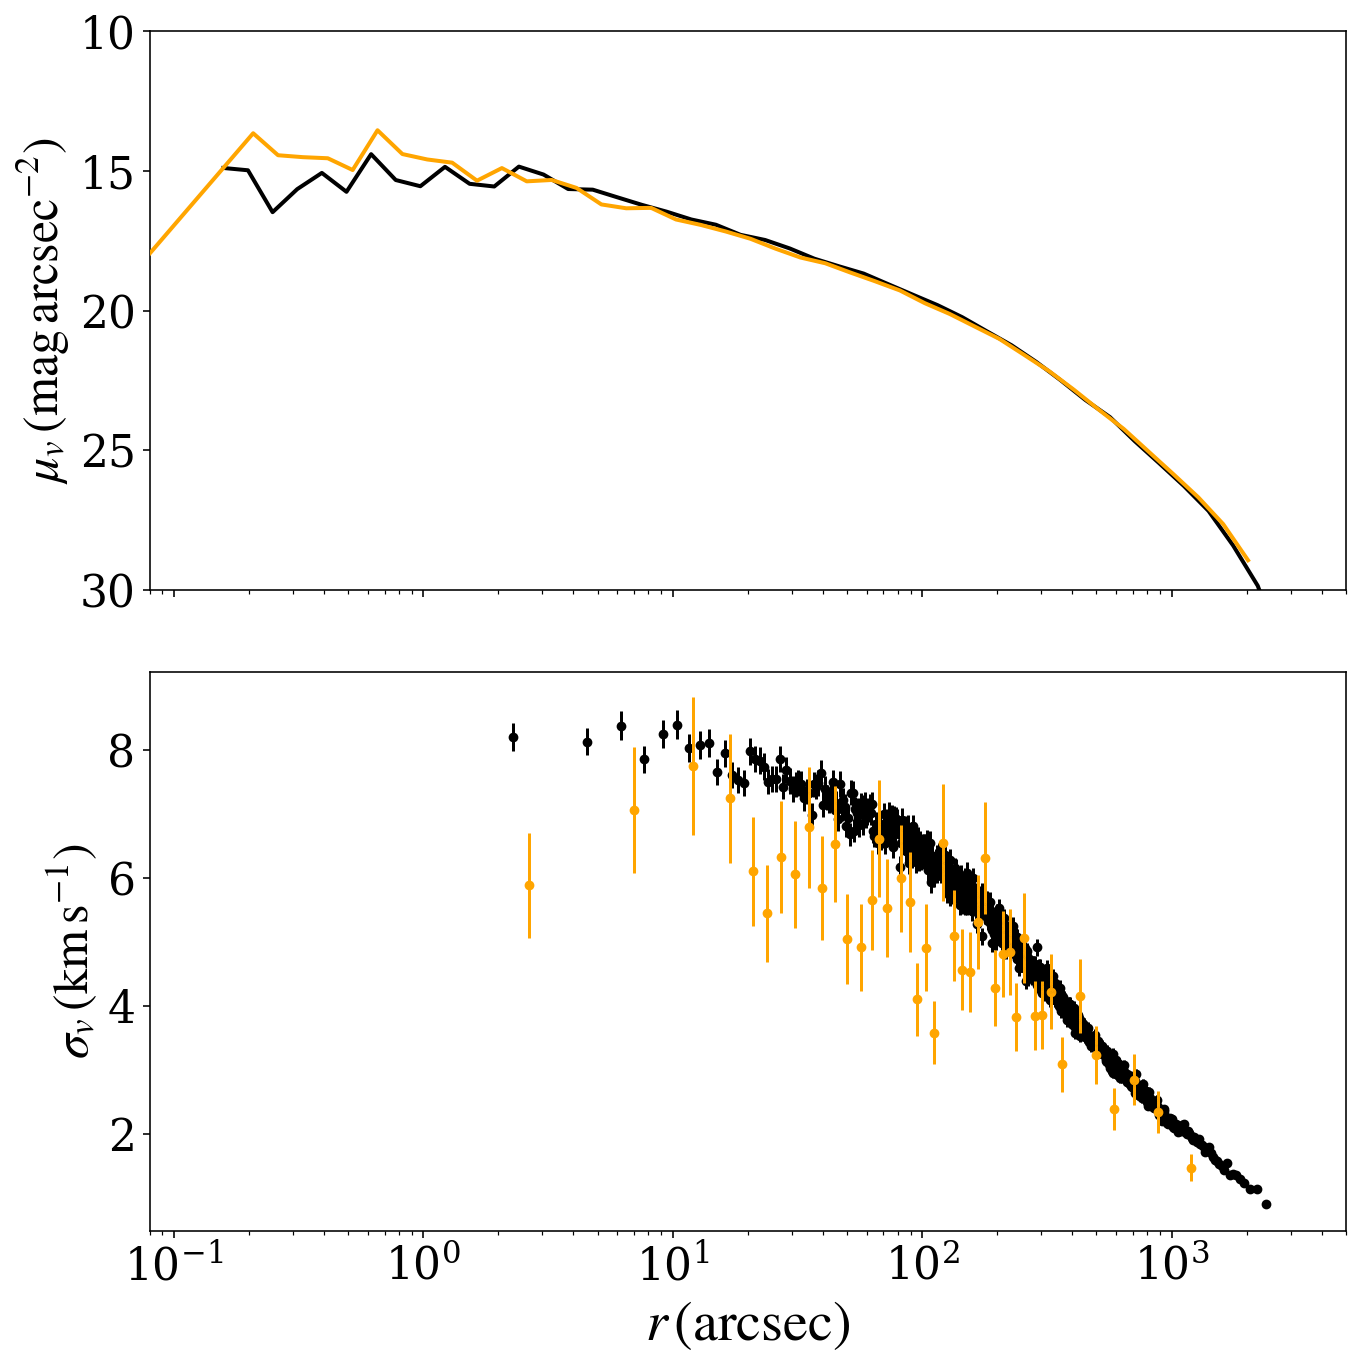

In [3]:
##Plot the best model using King profile
paths = ['/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.8-rg8-z0.0002_iccatalog_micwd_newnsfile_dynwdmt_wdmass/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/']

R_sun_obs=4.125
snapno = [459,597]

cs = ['k', 'orange']
####################################################      
##Plotting        
fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,10))
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')

    ######################################################
    ##Model data
    if xx == 0:
        snap2D = paths[xx]+'initial.snap'+str(snapno[xx])+'.2Dproj.dat.gz'
        snap2D_L15 = paths[xx]+'initial.snap'+str(snapno[xx])+'.2D_SBPLcut12_NCUT-1.dat'
        snap_veldisp = paths[xx]+'initial.snap'+str(snapno[xx])+'.vel_dispersion_vr_pm_700_0.dat'
    else:
        snap2D = paths[xx]+'initial.snap0'+str(snapno[xx])+'.2Dproj.dat.gz'
        snap2D_L15 = paths[xx]+'initial.snap0'+str(snapno[xx])+'.2D_SBPLcut15.dat'
        snap_veldisp = paths[xx]+'initial.snap0'+str(snapno[xx])+'.vel_dispersion_giants_25.dat'

    
    data5 = np.genfromtxt(snap2D_L15)
    arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
    SB = conversions.SB_converter(data5[:,3])
    SBerr = data5[:,6]/data5[:,5]*SB
    SD = conversions.SD_converter(data5[:,5], R_sun_obs)
    SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
     
    arcsec_cut = []
    SB_cut = []
    SBerr_cut = []

    for k in range(len(SB)):
        if arcsec[k] < 10 and SB[k] > 20:
            Nothing = 0
        else:
            arcsec_cut.append(arcsec[k])
            SB_cut.append(SB[k])
            
                
    data_vel = np.genfromtxt(snap_veldisp)
    R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
    sigma_model = data_vel[:,1]
    sigma_err_model = data_vel[:,2]


    #######################
    ##Plotting model data
    ax[0].plot(arcsec_cut, np.array(SB_cut), color = cs[xx], lw=2, zorder = 3)
    ax[1].scatter(R_model, sigma_model,s=15, color = cs[xx], zorder=3)
    ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = cs[xx], fmt='o',markersize=0.01,zorder=3)


    #######################
    ax[0].set_xscale('log')
    ax[0].set_xlim(0.08,5000)
    ax[0].set_ylim(30,10)
    ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
    ax[0].legend(loc='best',scatterpoints=1, ncol=1, prop={'size': 15}, frameon=False)
    

    ax[1].set_xscale('log')
    ax[1].set_xlim(0.08,5000)
    ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
    ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
    ax[1].legend(loc='best', prop={'size': 15}, numpoints=1, frameon=False)
        
fig.tight_layout()


13065.4
13090.0
13132.4
13050.6
13144.6
13041.6
13185.1


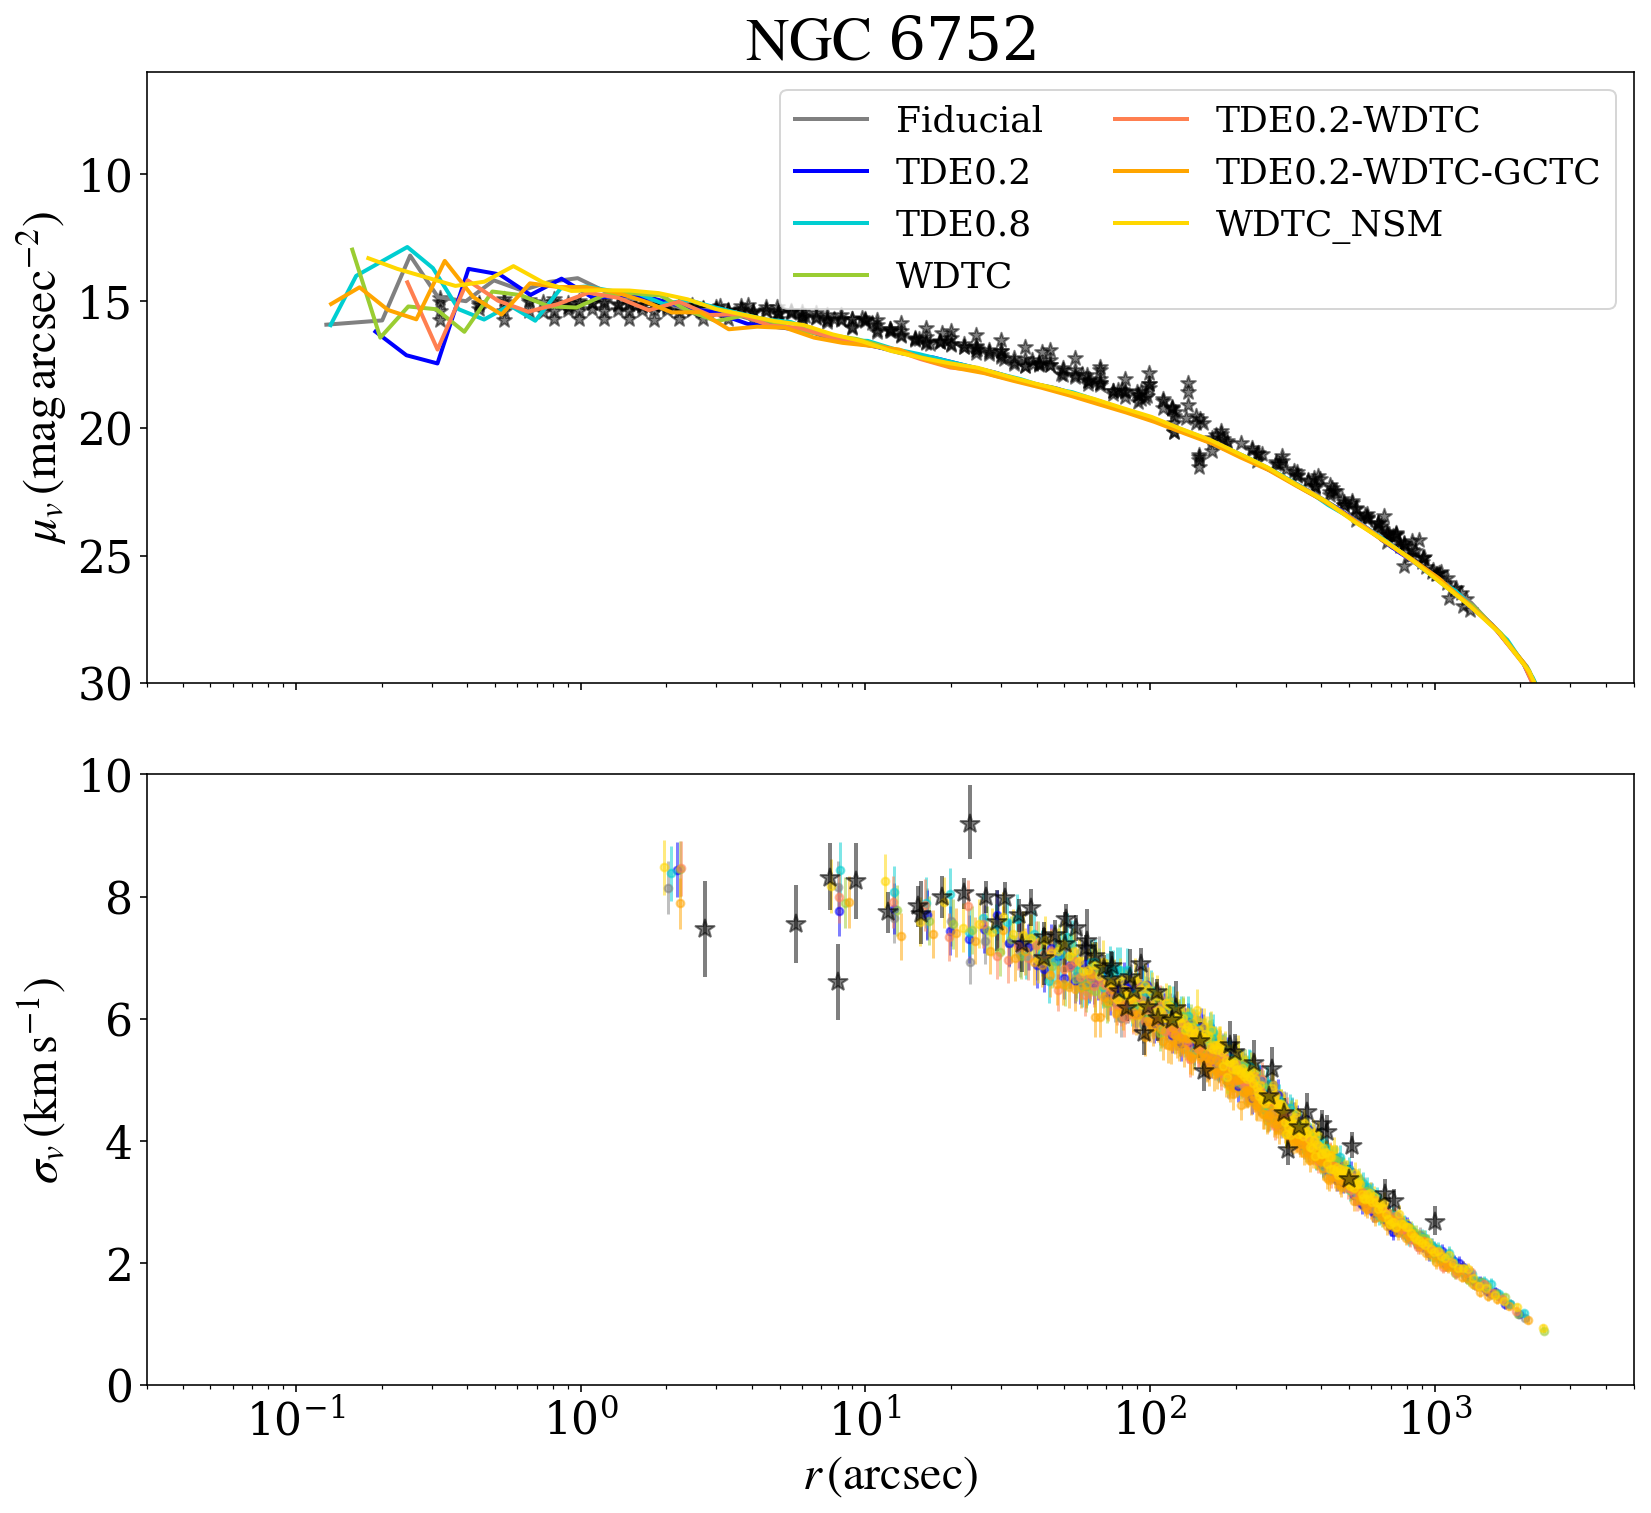

In [5]:
##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=4.125
ngcno='6752'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles_GEDR3.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(np.float(linet[2]))
        SB_t.append(np.float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_GEDR3.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,11))
ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=30)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.5, s=60)#, label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.5, c='k', lw=2.0)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.5,
              label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')     

###Models###
for xx in range(len(paths)):
    if xx>=0:
        snap2D = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
        snap2D_L12 = np.sort(glob(paths[xx]+'initial.snap*.2D_SBPLcut12_NCUT-1.dat'))
        snap_vel700 = np.sort(glob(paths[xx]+'initial.snap*.vel_dispersion_vr_pm_700_0.dat'))
    else:
        snap2D = [paths[xx]+'initial.snap0597.2Dproj.dat.gz']
        snap2D_L12 = [paths[xx]+'initial.snap0597.2D_SBPLcut15.dat']
        snap_vel700 = [paths[xx]+'initial.snap0597.vel_dispersion_giants_25.dat']
        #print(len(snap2D_L12), len(snap_vel700))
 
    for ii in range(0, len(snap2D_L12)):
        with open(snap2D_L12[ii], 'r') as f2D:
            first_line=f2D.readline()

        t_gyr = float(first_line.strip().split('=')[-1])
        if t_gyr>=13000.:
            print(t_gyr)
            data5 = np.genfromtxt(snap2D_L12[ii])
            arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
            SB = conversions.SB_converter(data5[:,3])
            SBerr = data5[:,6]/data5[:,5]*SB
            
            arcsec_cut = []
            SB_cut = []
            SBerr_cut = []
            for k in range(len(SB)):
                if arcsec[k] < 10 and SB[k] > 20:
                    Nothing = 0
                else:
                    arcsec_cut.append(arcsec[k])
                    SB_cut.append(SB[k])
                    #SBerr_cut.append(SBerr[k])
        
            datavel = np.genfromtxt(snap_vel700[ii])
            R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs)
            sigma_model = datavel[:,1]
            sigma_err_model = datavel[:,2]
        
            ax[0].plot(arcsec_cut, SB_cut, lw=2, color=cs[xx])
            ax[0].plot([10000,10000],[-5,-5], lw=2, label=model_label[xx], color=cs[xx])
            ax[1].scatter(R_model[::3], sigma_model[::3],s=15,zorder=2,alpha=0.5, color=cs[xx])
            ax[1].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt='o',
                           markersize=0.01,zorder=1,alpha=0.5, color=cs[xx])

            break

ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.03,5000)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\,arcsec^{-2}})$',fontsize=24)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})

ax[1].set_xscale('log')
ax[1].set_xlim(0.03,5000)
ax[1].set_ylim(0, 10)
ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=24)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=24)
#ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})

plt.subplots_adjust(hspace=0.1)
fig.tight_layout()

plt.savefig(savepath+'sbp_vdp_6752.pdf', dpi=300)

# Qcrit tests

4720
3754
4498


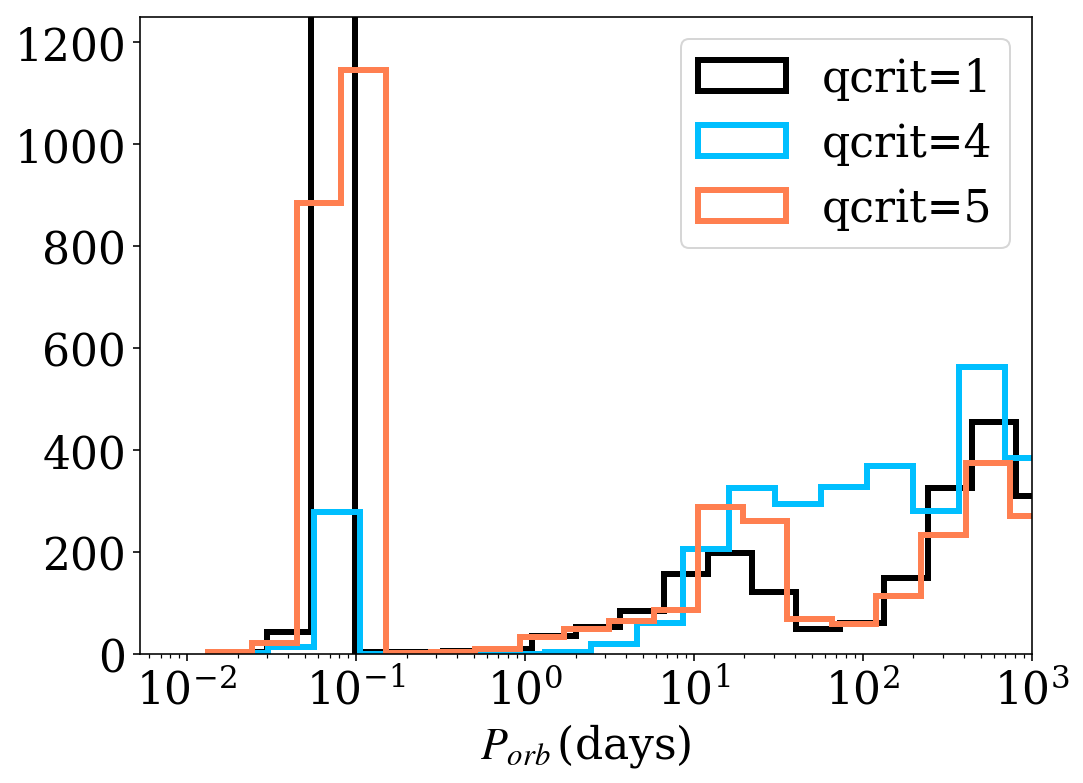

In [6]:
##COSMIC run NS-XX binaries with qcrit change
folders = ['qcrit1/', 'qcrit4/', 'qcrit5/']
colors = ['k', 'deepskyblue', 'coral']
labs = ['qcrit=1', 'qcrit=4', 'qcrit=5']

###Maybe can plot it this way?
def scatter_hist(x1, y1, lb, cs, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1, y1, s = 10,  label = lb, color = cs, alpha=0.5)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 30), 
                  log=True, color = cs, histtype = 'step', lw = 3)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 30), orientation='horizontal',
                 log=True, color = cs, histtype = 'step', lw = 3)
    
    ax.set_xlim(xmin = 0.004, xmax = 2)
    #ax.set_ylim(ymin = 0.01, ymax = 10**12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_c\, (\rm{M_{\odot}})$')
    ax.set_ylabel(r'$P_{orb}\,$(days)')
    ax.legend(loc = 'upper left', fontsize = 18, frameon = False)
    
    
    ax_histx.set_yticks([1., 100., 500.])
    ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
#fig = plt.figure(figsize=(10, 10))

#ax = fig.add_axes(rect_scatter)
#ax_histx = fig.add_axes(rect_histx, sharex=ax)
#ax_histy = fig.add_axes(rect_histy, sharey=ax)

fig,ax = plt.subplots(figsize=[8,6])
for xx in range(len(folders)):
    conv = pd.read_hdf('/projects/b1095/syr904/cosmic/qcrit_check/'+folders[xx]+'dat_kstar1_13_kstar2_0_12_SFstart_13700.0_SFduration_0.0_metallicity_0.0002.h5', 
                       key='conv')
    bcm = pd.read_hdf('/projects/b1095/syr904/cosmic/qcrit_check/'+folders[xx]+'dat_kstar1_13_kstar2_0_12_SFstart_13700.0_SFduration_0.0_metallicity_0.0002.h5', 
                       key='bcm')
    bpp = pd.read_hdf('/projects/b1095/syr904/cosmic/qcrit_check/'+folders[xx]+'dat_kstar1_13_kstar2_0_12_SFstart_13700.0_SFduration_0.0_metallicity_0.0002.h5', 
                       key='bpp')
    
    #print(bcm)
    #print(bpp)
    #print(len(bcm.loc[bcm.tphys==13700., ['kstar_1','kstar_2','mass_1','mass_2','porb']]))
    print(len(bcm.loc[(bcm.tphys==13700.) & (bcm.kstar_1==13)& (bcm.omega_spin_1>6.6e9), 
                      ['kstar_1','kstar_2','mass_1','mass_2','porb']]))
    mc = bcm.loc[(bcm.tphys==13700.) & (bcm.kstar_1==13) & (bcm.omega_spin_1>6.6e9), 'mass_2']
    porb = bcm.loc[(bcm.tphys==13700.) & (bcm.kstar_1==13) & (bcm.omega_spin_1>6.6e9), 'porb']

    ax.hist(porb, #bins = 30,
            bins=np.logspace(np.log10(np.min(porb)), np.log10(np.max(porb)), 30),
            cumulative=False, density=False, log=False,
            color=colors[xx], histtype='step', lw=3, label = labs[xx])
    #scatter_hist(mc, porb, labs[xx], colors[xx], ax, ax_histx, ax_histy)

ax.set_xscale('log')
ax.set_xlabel(r'$P_{orb}\,$(days)')
ax.set_xlim(xmax=1000)
ax.set_ylim(ymax = 1250)
ax.legend(loc = 'upper right')
fig.tight_layout()

plt.savefig(savepath+'qcrit_comp.pdf', dpi=300)

In [ ]:
##Number of NSs and BHs comparison between old 6752 and new 6752 models
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_ICold_wdmass_nstde_test/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

ns_new = np.genfromtxt(path_new+'initial.ns.dat')
bh_new = np.genfromtxt(path_new+'initial.bh.dat')
tconv_new = dyn.conv('t', path_new+'initial.conv.sh')

ns_old = np.genfromtxt(path_old+'initial.ns.dat')
bh_old = np.genfromtxt(path_old+'initial.bh.dat')
tconv_old = dyn.conv('t', path_old+'initial.conv.sh')


plt.figure(figsize = (8,6))
plt.plot(ns_new[:,0], ns_new[:,1], label='NS', 
         color = 'orange', alpha=0.8)
plt.plot(ns_old[:,0]*tconv_old, ns_old[:,1],
         color = 'orange', alpha=0.8, ls = '--')

plt.plot(bh_new[:,1]*tconv_new, bh_new[:,2], label='BH', 
         color = 'k', alpha=0.8)
plt.plot(bh_old[:,1]*tconv_old, bh_old[:,2],
         color = 'k', alpha=0.8, ls = '--')

plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('t(Myr)')
plt.ylabel('N')
plt.xlim(xmin = 0.)
plt.ylim(ymin = 0.)
plt.legend()

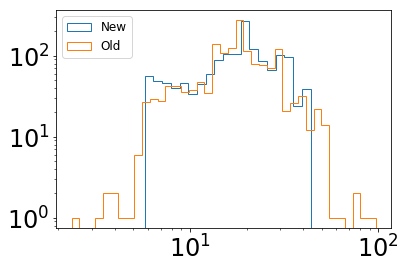

In [21]:
##Compare mass of BH at formation
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

bhform_new = np.genfromtxt(path_new+'initial.bhformation.dat')
mbh_new = bhform_new[:,6]
mbh_old = []
with open(path_old+'initial.bhformation.dat', 'r') as fbhf:
    next(fbhf)
    for line in fbhf:
        data = line.split()
        mbh_old.append(float(data[6]))

plt.figure()
plt.hist(mbh_new, bins = np.logspace(np.min(np.log10(mbh_new)), np.max(np.log10(mbh_new)), 20), 
         histtype='step', label = 'New')
plt.hist(mbh_old, bins = np.logspace(np.min(np.log10(mbh_old)), np.max(np.log10(mbh_old)), 40), 
         histtype='step', label = 'Old')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'upper left', fontsize=12)

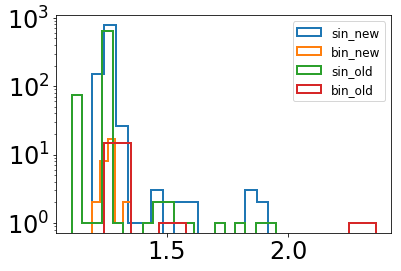

In [6]:
##Compare mass of NSs
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

snap341 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', snapshot_name='/341(t=19.263855)',
                        conv=path_new+'initial.conv.sh')
binflag = snap341.data['binflag']
m_sin = snap341.data['m_MSUN'][binflag!=1]
m0 = snap341.data['m0_MSUN'][binflag==1]; m1 = snap341.data['m1_MSUN'][binflag==1]
ktype = snap341.data['startype'][binflag!=1]
k0 = snap341.data['bin_startype0'][binflag==1]; k1 = snap341.data['bin_startype1'][binflag==1]

m12_sin_new = list(m_sin[ktype==13])
m12_bin_new = list(m0[k0==13])+list(m1[k1==13])

m12_sin_old = []
m12_bin_old = []
with gzip.open(path_old+'initial.snap0597.dat.gz', 'r') as fsnap:
    next(fsnap); next(fsnap)
    for line in fsnap:
        data = line.split()
        if int(data[7])!=1 and int(data[14])==13:
            m12_sin_old.append(float(data[1]))
        elif int(data[7])==1 and int(data[17])==13:
            m12_bin_old.append(float(data[8]))
        elif int(data[7])==1 and int(data[18])==13:
            m12_bin_old.append(float(data[9]))
            
plt.figure()
plt.hist(m12_sin_new, histtype='step', lw = 2, label = 'sin_new', bins=15)
plt.hist(m12_bin_new, histtype='step', lw = 2, label = 'bin_new', bins=5)
plt.hist(m12_sin_old, histtype='step', lw = 2, label = 'sin_old', bins=20)
plt.hist(m12_bin_old, histtype='step', lw = 2, label = 'bin_old', bins=10)

plt.yscale('log')
plt.legend(fontsize=12)

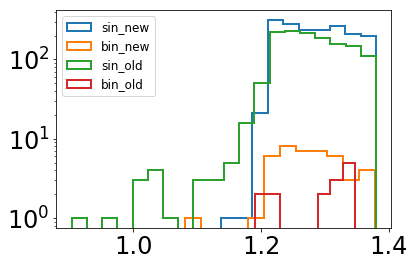

In [3]:
##Compare mass of ONe WDs
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

snap341 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', snapshot_name='/341(t=19.263855)',
                        conv=path_new+'initial.conv.sh')
binflag = snap341.data['binflag']
m_sin = snap341.data['m_MSUN'][binflag!=1]
m0 = snap341.data['m0_MSUN'][binflag==1]; m1 = snap341.data['m1_MSUN'][binflag==1]
ktype = snap341.data['startype'][binflag!=1]
k0 = snap341.data['bin_startype0'][binflag==1]; k1 = snap341.data['bin_startype1'][binflag==1]

m12_sin_new = list(m_sin[ktype==12])
m12_bin_new = list(m0[k0==12])+list(m1[k1==12])

m12_sin_old = []
m12_bin_old = []
with gzip.open(path_old+'initial.snap0597.dat.gz', 'r') as fsnap:
    next(fsnap); next(fsnap)
    for line in fsnap:
        data = line.split()
        if int(data[7])!=1 and int(data[14])==12:
            m12_sin_old.append(float(data[1]))
        elif int(data[7])==1 and int(data[17])==12:
            m12_bin_old.append(float(data[8]))
        elif int(data[7])==1 and int(data[18])==12:
            m12_bin_old.append(float(data[9]))
            
plt.figure()
plt.hist(m12_sin_new, histtype='step', lw = 2, label = 'sin_new', bins=10)
plt.hist(m12_bin_new, histtype='step', lw = 2, label = 'bin_new', bins=12)
plt.hist(m12_sin_old, histtype='step', lw = 2, label = 'sin_old', bins=20)
plt.hist(m12_bin_old, histtype='step', lw = 2, label = 'bin_old', bins=8)

plt.yscale('log')
plt.legend(fontsize=12)

In [9]:
##BHs at 13Gyr
snap341 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', 
                snapshot_name='/341(t=19.263855)', conv=path_new+'initial.conv.sh')

snap0 = cmct.Snapshot(fname=path_new+'initial.snapshots.h5', 
                snapshot_name='/0(t=0)', conv=path_new+'initial.conv.sh')

binflag = snap341.data['binflag']
id_sin = snap341.data['id'][binflag!=1]
id0 = snap341.data['id0'][binflag==1]; id1 = snap341.data['id1'][binflag==1]
ktype = snap341.data['startype'][binflag!=1]
k0 = snap341.data['bin_startype0'][binflag==1]; k1 = snap341.data['bin_startype1'][binflag==1]

bh_sin = list(id_sin[ktype==14])
bh_bin = list(id0[k0==14])+list(id1[k1==14])
print(bh_sin, bh_bin)

binflag0 = snap0.data['binflag']
id_sin0 = np.array(snap0.data['id'][binflag0!=1])
id00 = np.array(snap0.data['id0'][binflag0==1]); id10 = np.array(snap0.data['id1'][binflag0==1])
if 109424 in id_sin0 or 109424 in id00 or 109424 in id10:
    print('yes 109424')
if 812765 in id_sin0 or 812765 in id00 or 812765 in id10:
    print('yes 812765')
    
for ii in range(len(id10)):
    if float(id10[ii]) == 812765:
        print('found it')

[979712, 837226, 109424, 892893, 1008493, 520966] [812765, 988416, 1500692, 868210, 862255, 1153880, 1343428]
yes 109424
yes 812765


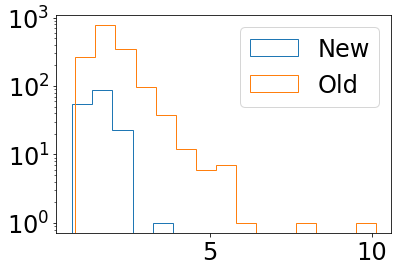

In [29]:
##Compare WD collisions between old and new 6752 models
path_new = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_tcoff/'
path_old = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

wd_coll_new = np.genfromtxt(path_new+'wd_coll_all.dat')
wd_coll_old = np.genfromtxt(path_old+'wd_coll_all.dat')

mcoll_new = wd_coll_new[:,4]
mcoll_old = wd_coll_old[:,4]

plt.figure()
plt.hist(mcoll_new, bins = 5, histtype='step', label = 'New')
plt.hist(mcoll_old, bins = 15, histtype='step', label = 'Old')

plt.yscale('log')

plt.legend(loc='best')